# Gene Expression Variance Analysis
## Predicting Cis-Regulatory Effects on Expression Variability

This notebook analyzes how genetic variants near gene transcription start sites (TSS) contribute to expression variability. We use AI-based predictions from FlashZoi to estimate the cumulative effect of common variants on gene expression variance.

### Overview
- **Dataset**: 15 genes from chromosome 20
- **Method**: FlashZoi predictions of variant effects on expression
- **Goal**: Understand the relationship between variant properties and predicted expression variance

### Table of Contents
1. [Data Loading and Summary Statistics](#1-data-loading-and-summary-statistics)
2. [Distribution Analysis](#2-distribution-analysis)
3. [Correlation Analysis](#3-correlation-analysis)
4. [Exploratory Findings](#4-exploratory-findings)
5. [Validation Against Expression Data](#5-validation-against-expression-data)

## 1. Data Loading and Summary Statistics

We start by loading the FlashZoi predictions for each gene and computing summary statistics that will help us understand the relationship between genetic variants and expression variability.

### 1.1 Mathematical Framework

For each gene, we analyze how genetic variants contribute to expression variability. Here's our approach:

#### Data Filtering and Preparation
For each gene $g$, we filter variants to include only **biallelic SNPs** with minor allele frequency (AF) ≥ 0.01. The filtered variant set is:

$$\mathcal{V}_g = \{v_1, v_2, \ldots, v_{N_g}\}$$

where each variant $v_i$ has:
- **Predicted expression effect**: $\Delta_i = 	ext{FlashZoi-predicted-effect}(v_i)$  
- **Minor allele frequency**: $f_i = 	ext{AF}(v_i)$

#### Computed Metrics
The following per-gene summary statistics capture different aspects of predicted regulatory burden:

| **Metric** | **Formula** | **Variable** | **Interpretation** |
|------------|-------------|--------------|-------------------|
| **SNP Count** | $N_g = |\mathcal{V}_g|$ | `num_snps` | Total common variants near TSS |
| **Per-Variant Variance** | $	ext{VAR\_I}_i = \Delta_i^2 \cdot 2f_i(1-f_i)$ | `VAR_I` | Individual variant contribution |
| **Gene-Level Cis-Variance** | $	ext{Var}^{	ext{cis}}_g = \sum_{i \in \mathcal{V}_g} 	ext{VAR\_I}_i$ | `predicted_cis_variance` | **Total predicted variance** |
| **Mean/Median AF** | $\overline{f}_g = frac{1}{N_g}\sum_i f_i$ | `mean_AF`, `median_AF` | Average allele frequency |
| **Mean/Median Effect** | $\overline{\Delta}_g = frac{1}{N_g}\sum_i \Delta_i$ | `mean_DELTA`, `median_DELTA` | Average effect magnitude |
| **Mean/Median Variance** | $\overline{	ext{VAR\_I}}_g = frac{1}{N_g}\sum_i 	ext{VAR\_I}_i$ | `mean_VAR_I`, `median_VAR_I` | Average per-variant contribution |

---

> **Important note**: The term $2f_i(1-f_i)$ represents the **expected heterozygosity** under Hardy-Weinberg equilibrium, converting squared effects to additive genetic variance contributions.

### 1.2 Understanding the Data

- Each gene has multiple genetic variants near its start site
- Each variant can potentially affect how much the gene is expressed
- We want to predict the total variability in expression caused by all these variants combined

A variant contributes more to expression variability if:
1. It has a large effect on expression (large $\Delta_i$)
2. It's common enough in the population to affect many people (moderate $f_i$)

The mathematics above captures this by multiplying the squared effect size with the population variance of the allele frequency.


In [40]:
import os, glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import pearsonr, spearmanr
import os
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
from sklearn.linear_model import LinearRegression
import os, glob, base64
from pathlib import Path
from itertools import combinations

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from scipy.stats import pearsonr, spearmanr
import statsmodels.api as sm
from IPython.display import HTML, display

import numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import pearsonr
from pathlib import Path
import base64, os
from IPython.display import HTML, display


import numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt
from pathlib import Path
import statsmodels.api as sm
from scipy.stats import pearsonr, spearmanr
from sklearn.utils import resample
from IPython.display import display, HTML
import base64, random

import numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from pathlib import Path, PurePath
import base64, io, textwrap
from IPython.display import display, HTML

import os, base64, numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt
from pathlib import Path
from scipy.stats import pearsonr, spearmanr
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import OLSInfluence
from IPython.display import HTML, display

variants_scored_dir = "../../data/output/dataset1/flashzoi_outputs/variants_scored"
cache_file = "../../data/intermediate/flashzoi_gene_stats.tsv"

gtex_expr_file = "../../data/initial/GTEx_Analysis_2022-06-06_v10_RNASeQCv2.4.2_gene_median_tpm.gct"
gtex_filtered_genes = "../../data/intermediate/GTEx_chr20_mane_TPM.tsv"

gtex_sample_expr_file = "../../data/initial/GTEx_Analysis_v10_RNASeQCv2.4.2_gene_tpm.gct.gz"
sample_annot_file = "../../data/initial/GTEx_Analysis_v10_Annotations_SampleAttributesDS.txt"

gene_metrics_vgh = "../../data/initial/gene_metrics_vgh_202407.tsv.gz"

In [6]:
if os.path.exists(cache_file):
    var_df = pd.read_csv(cache_file, sep="\t")
    print(f"Loaded cached gene summary table: {cache_file}")
else:
    records = []
    for folder in glob.glob(os.path.join(variants_scored_dir, "*")):
        gene_id = os.path.basename(folder)
        var_file = os.path.join(folder, f"{gene_id}_variants.tsv")
        if not os.path.isfile(var_file):
            continue
        df = pd.read_csv(var_file, sep="\t")
        df.columns = df.columns.str.upper()
        if df.empty or not {"VAR_I", "AF", "DELTA"}.issubset(df.columns):
            continue
        records.append({
            "gene_id": gene_id,
            "predicted_cis_variance": df["VAR_I"].sum(), # total predicted cis genetic variance
            "num_snps": len(df), # number of SNPs in the gene window
            "mean_AF": df["AF"].mean(), # mean allele frequency of SNPs
            "median_AF": df["AF"].median(),
            "mean_DELTA": df["DELTA"].mean(),
            "median_DELTA": df["DELTA"].median(),
            "mean_VAR_I": df["VAR_I"].mean(),
            "median_VAR_I": df["VAR_I"].median()
        })
    var_df = pd.DataFrame(records)
    var_df.to_csv(cache_file, sep="\t", index=False)
    print(f"Saved gene summary to: {cache_file}")

print(var_df.shape)
print(var_df.head())

Loaded cached gene summary table: ../../data/intermediate/flashzoi_gene_stats.tsv
(15, 9)
           gene_id  predicted_cis_variance  num_snps   mean_AF  median_AF  \
0  ENSG00000131061              197.062469     11727  0.025363   0.000512   
1  ENSG00000197122              238.118638     12399  0.038575   0.000527   
2  ENSG00000196839              260.276776     11522  0.030893   0.000519   
3  ENSG00000170191              184.422547     13106  0.034233   0.000565   
4  ENSG00000101333              129.060822     10818  0.043196   0.000598   

   mean_DELTA  median_DELTA  mean_VAR_I  median_VAR_I  
0   -0.793469     -0.793469    0.016804      0.000644  
1   -0.770944     -0.770944    0.019205      0.000617  
2   -0.842143     -0.842143    0.022590      0.000735  
3   -0.604251     -0.604251    0.014072      0.000412  
4   -0.501769     -0.501769    0.011930      0.000301  


1. Cis Variance (VAR_I sum):
- Shows the total predicted variability in expression caused by common SNPs near each gene
- Higher values suggest a gene’s expression is more sensitive to naturally occurring genetic variation
2. Number of SNPs (num_snps):
- genes have about 10,000 to 13,000 SNPs per gene window (±262 kb).
- Should continue from here exploring variance, it's probably not only driven by SNP count
3. Allele Frequency (mean_AF, median_AF):
- Mean AF is around 2.5–4%, while median AF is very low (~0.05%) → implies the variant effect distribution is skewed toward rare variants
- These rare variants may disproportionately contribute to variance through large Δ values.
4. Regulatory Effect (mean_DELTA, median_DELTA):
- Meann and median Δ are consistently strongly negative, indicating the typical variant is predicted to reduce expression (in log fold-change units).
5. per-Variant Effect (mean_VAR_I, median_VAR_I):
- average per-SNP contribution to variance is around 0.012–0.022, but median is much lower
- few high-impact SNPs dominate the predicted variance per gene.

## 2. Distribution overview of gene-level predicted variance

Distribution Of Predicted Cis Variance,Snp Count Vs Cis Variance
Raincloud Variance By Snp Quartile,Hexbin Abs Delta Vs Af
Pairgrid Gene Metrics,

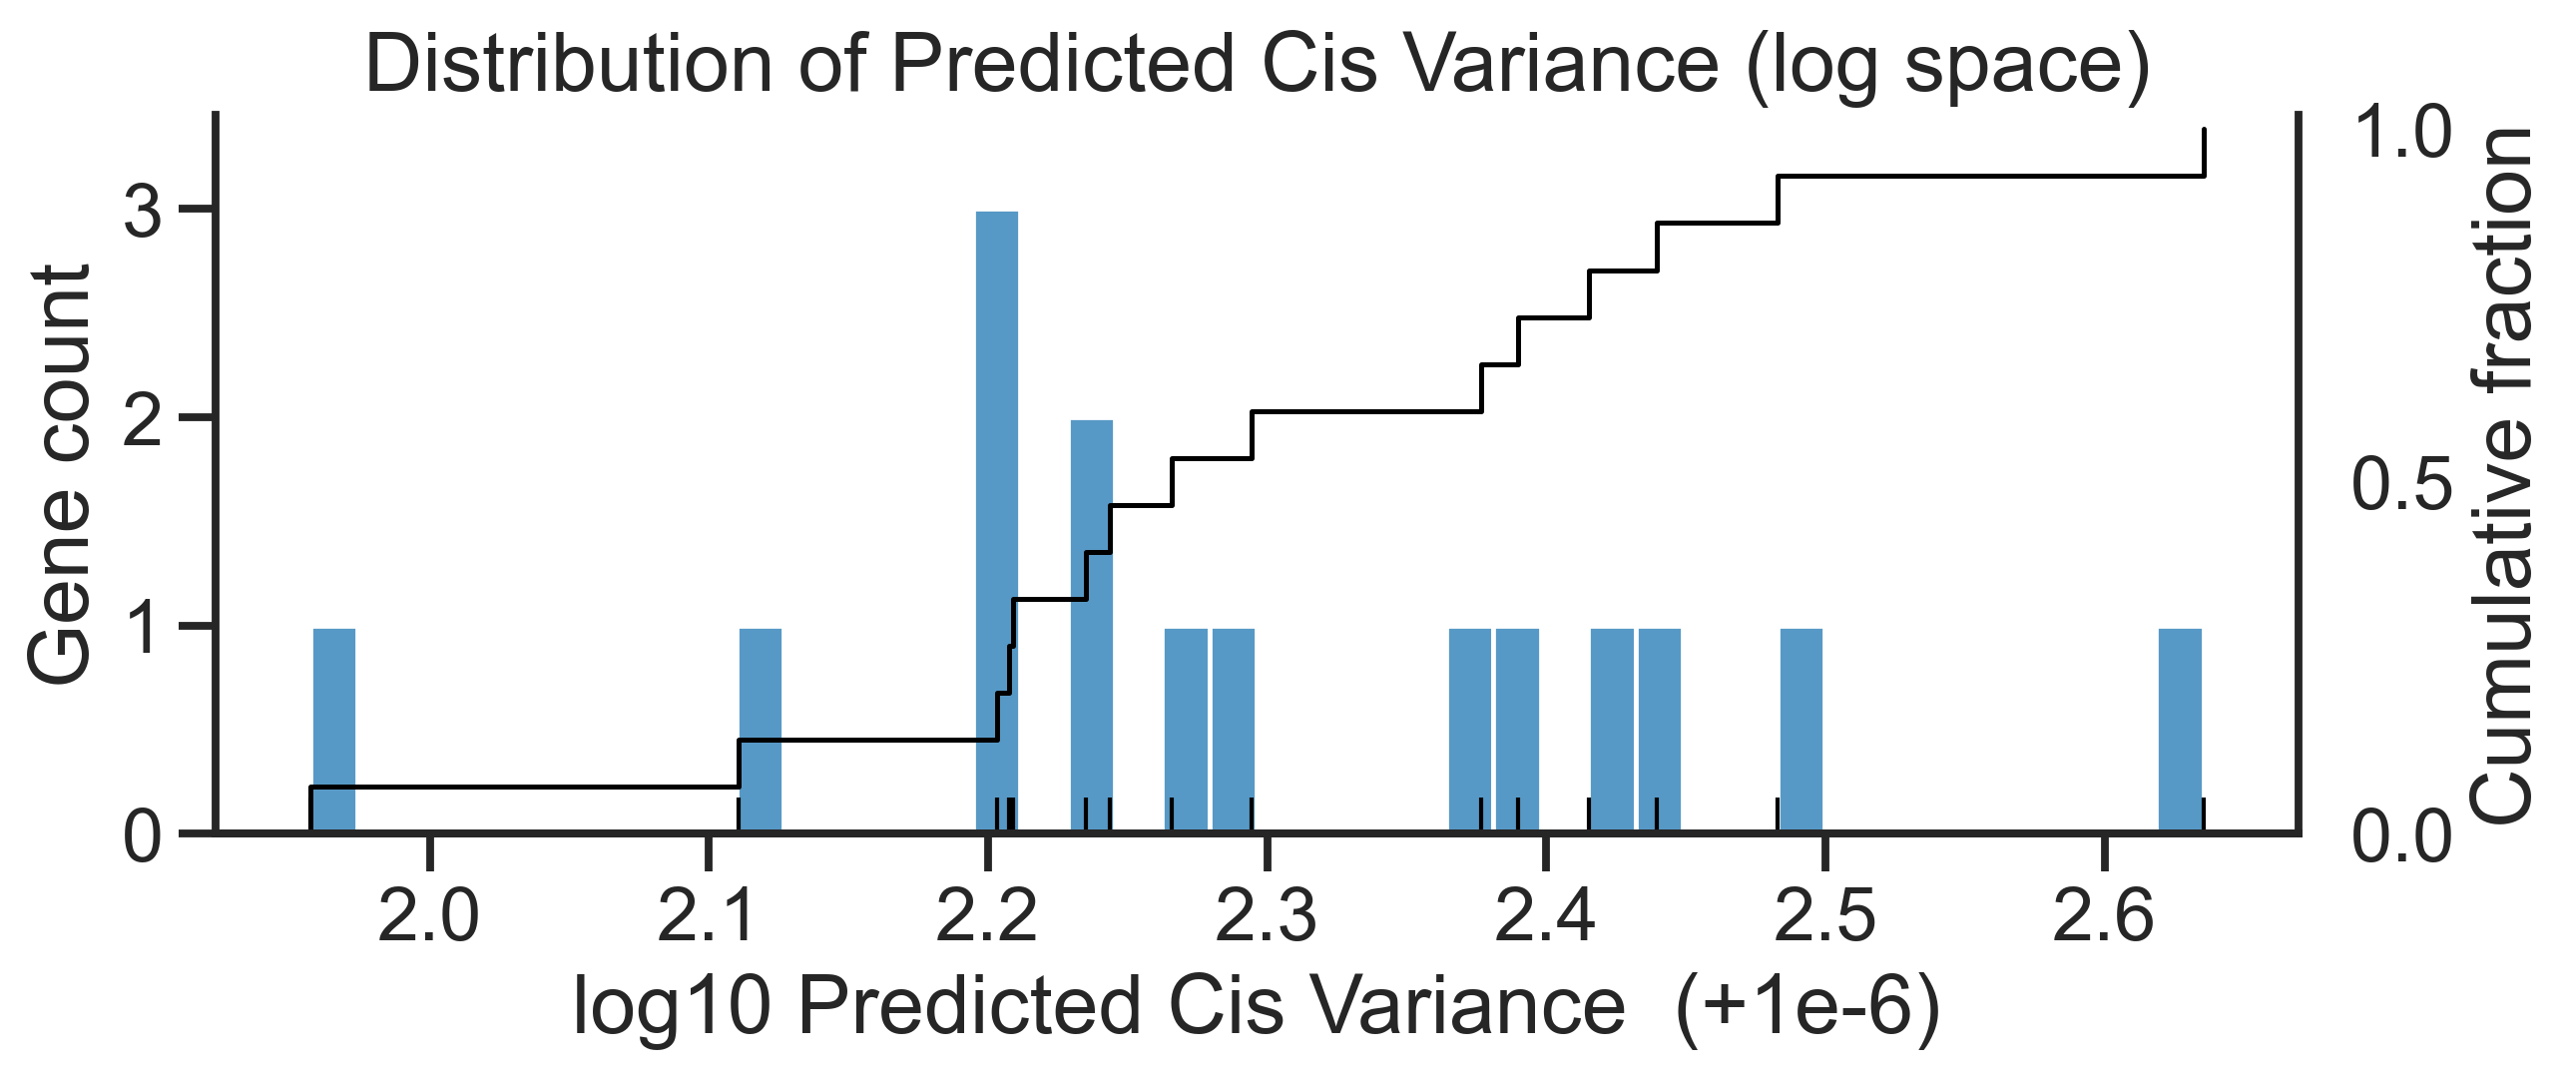
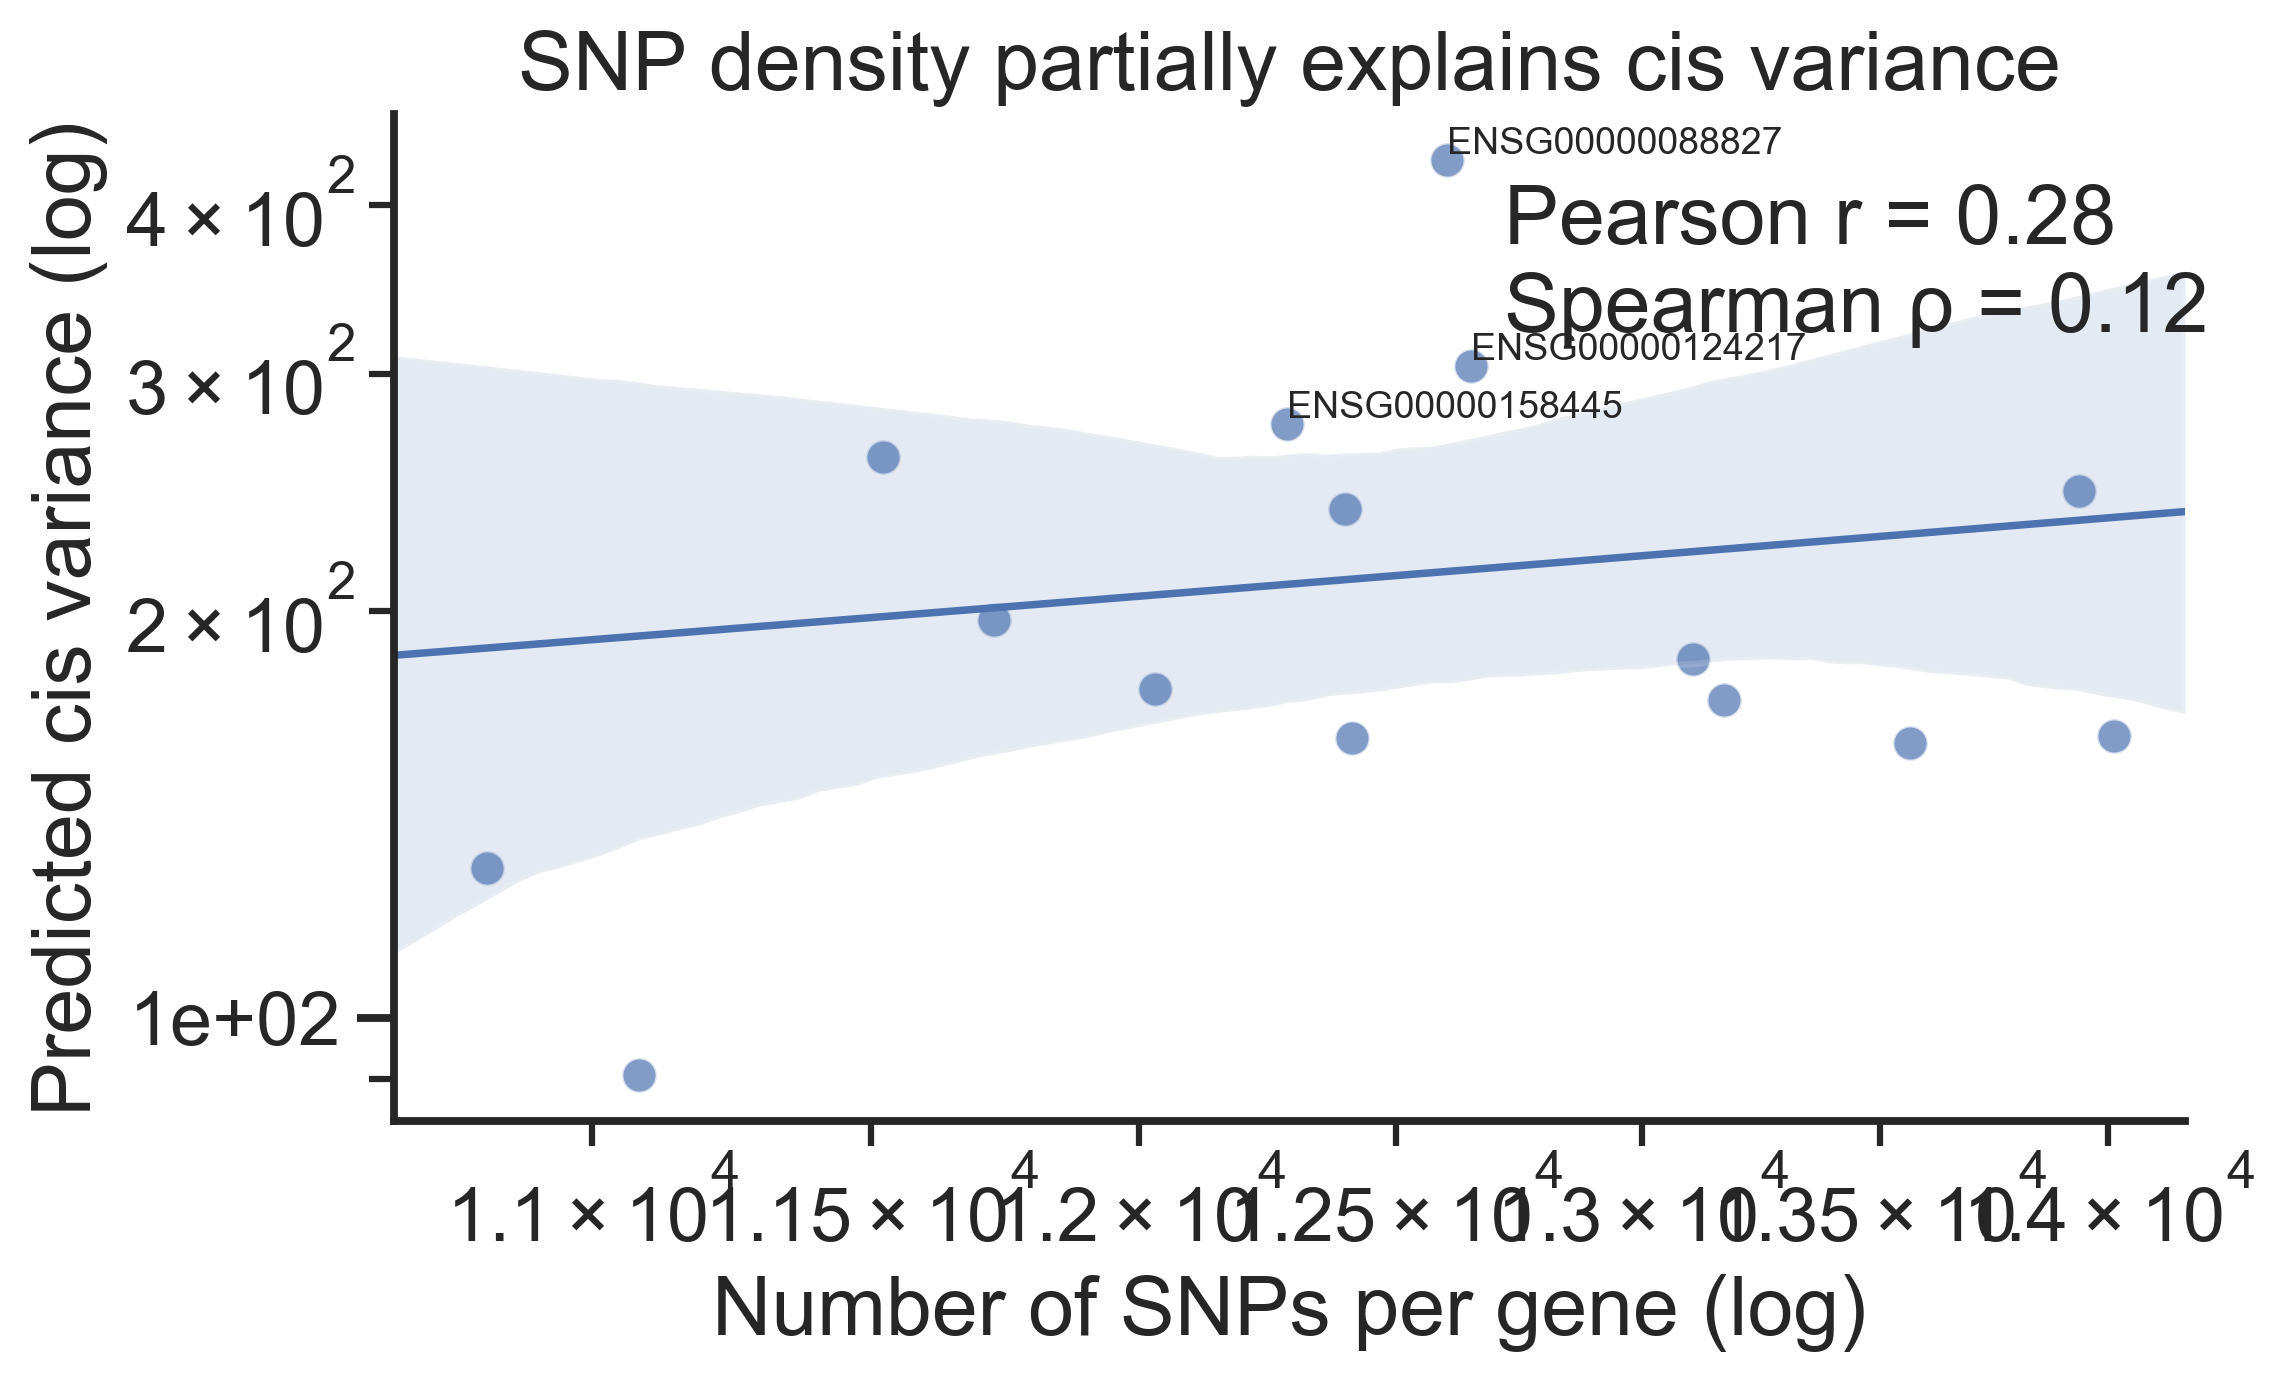
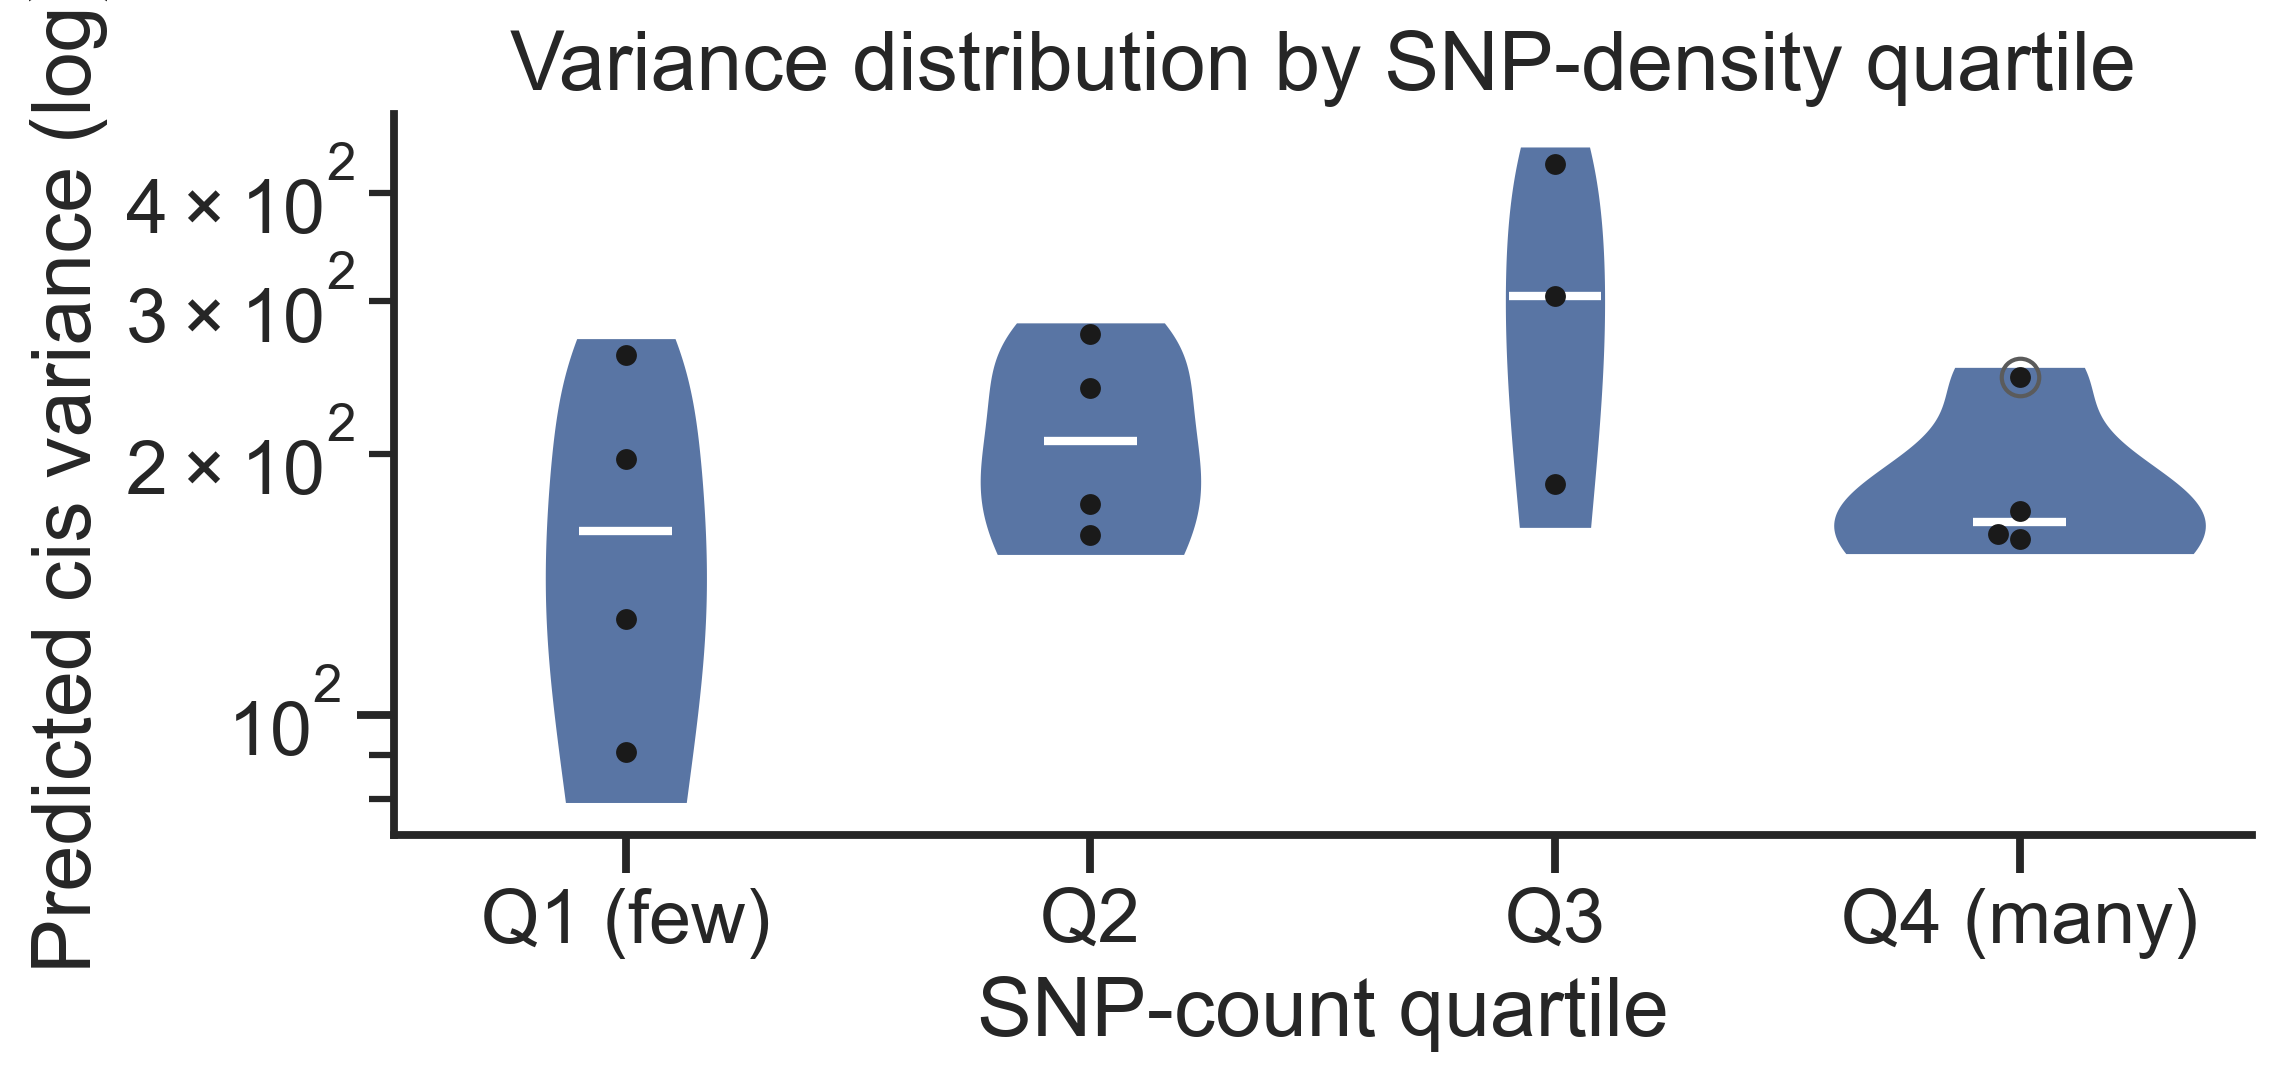
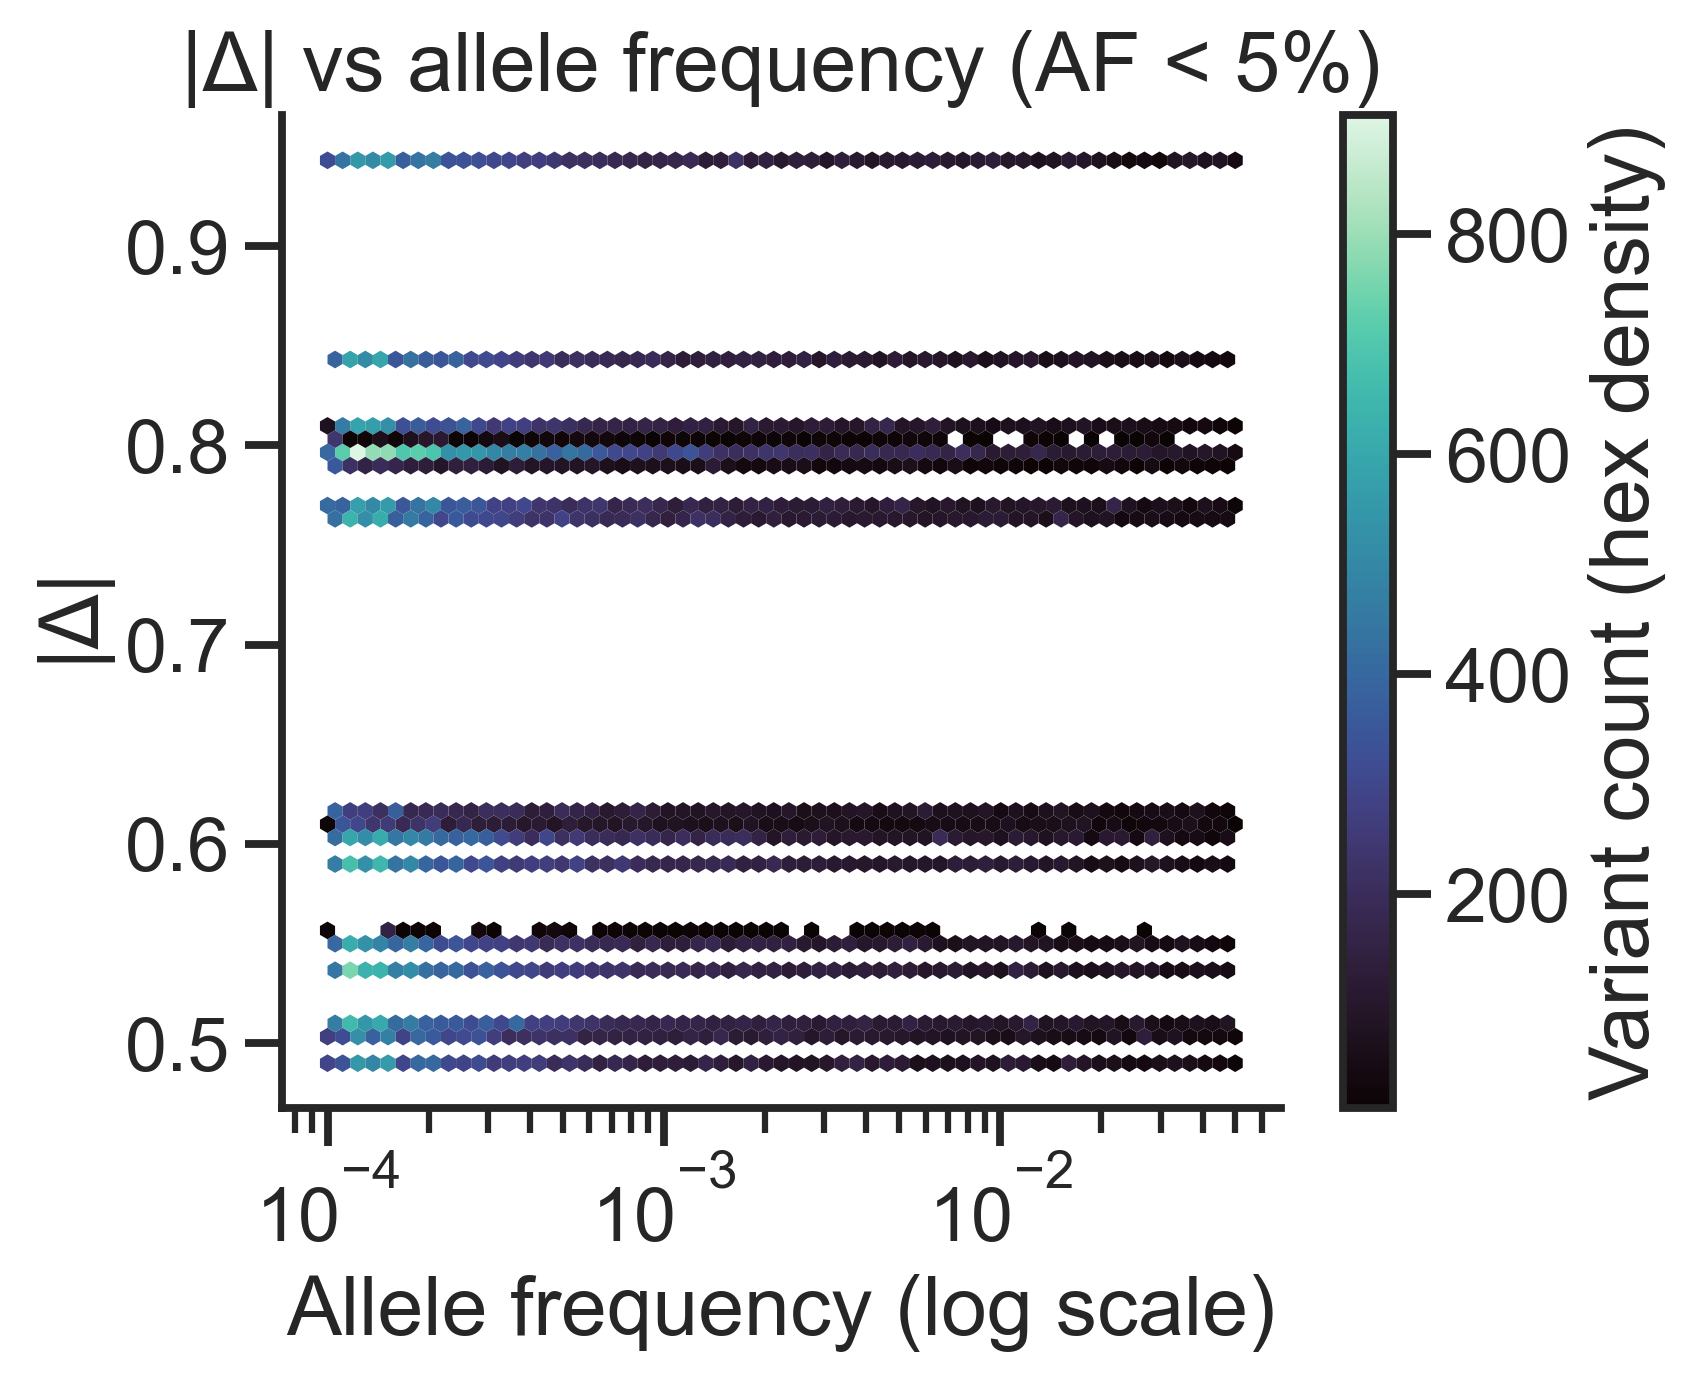
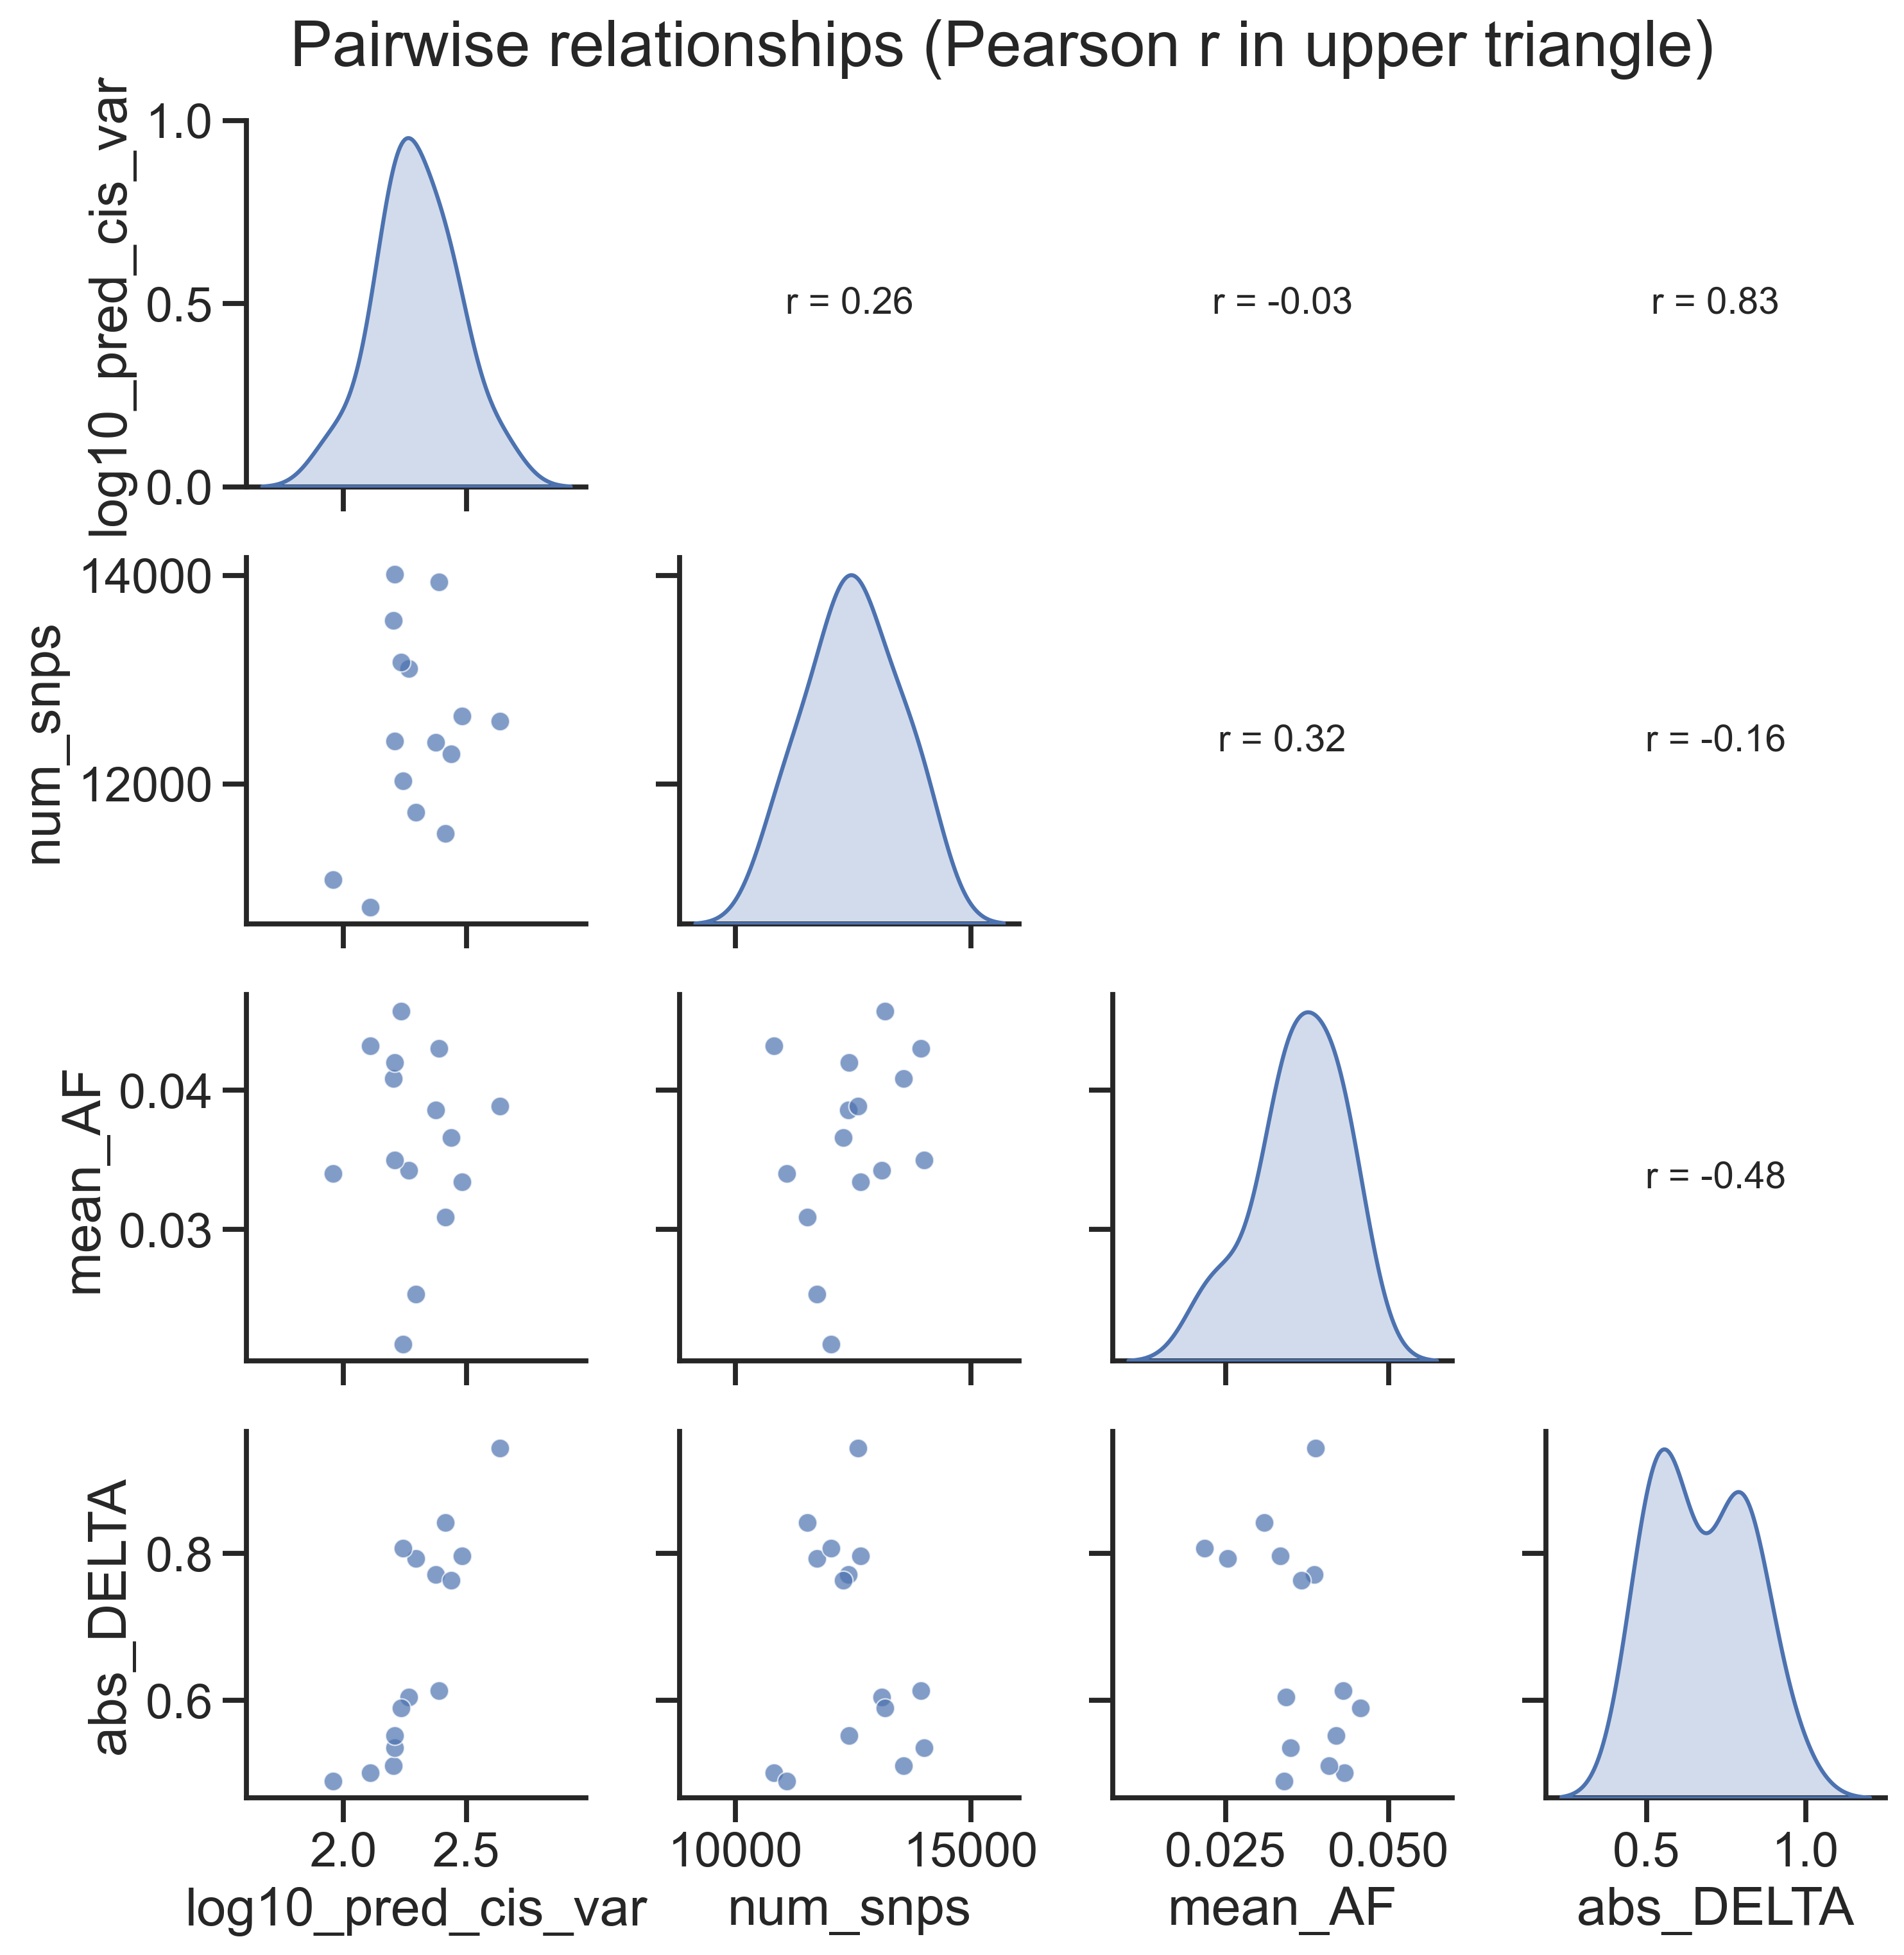


Saved 5 figure(s) to: /Users/markus/seq2expr-variance/3_aggregate/dataset1/figures



In [7]:
OUT_DIR = Path("/Users/markus/seq2expr-variance/3_aggregate/dataset1/figures")
OUT_DIR.mkdir(parents=True, exist_ok=True)

def sci_fmt(x, _):
    return f"{x:.0e}"

def slugify(t):
    return (
        t.lower()
         .replace(" ", "_")
         .replace("|", "")
         .replace("Δ", "delta")
         .replace("–", "-")
         .replace("(", "")
         .replace(")", "")
         .replace("%", "pct")
    )

def save_png(fig, title):
    path = OUT_DIR / f"{slugify(title)}.png"
    fig.savefig(path, dpi=300, bbox_inches="tight")
    plt.close(fig)
    return path

if "log10_pred_cis_var" not in var_df.columns:
    var_df["log10_pred_cis_var"] = np.log10(var_df["predicted_cis_variance"] + 1e-6)

if "abs_DELTA" not in var_df.columns:
    var_df["abs_DELTA"] = var_df["mean_DELTA"].abs()

var_df["snp_qbin"] = pd.qcut(
    var_df["num_snps"], 4,
    labels=["Q1 (few)", "Q2", "Q3", "Q4 (many)"]
)


sns.set_theme(
    context="talk",
    style="ticks",
    font_scale=1.1,
    rc={"axes.spines.right": False, "axes.spines.top": False, "figure.autolayout": True},
)

fig_paths = []  # collect pngs


fig, ax = plt.subplots(figsize=(9, 4))
sns.histplot(var_df["log10_pred_cis_var"], bins=40, kde=False, ax=ax, color="#1f77b4")
sns.rugplot(var_df["log10_pred_cis_var"], ax=ax, height=.05, color="black")
ax.set_title("Distribution of Predicted Cis Variance (log space)")
ax.set_xlabel("log10 Predicted Cis Variance  (+1e-6)")
ax.set_ylabel("Gene count")
ax2 = ax.twinx()
sns.ecdfplot(var_df["log10_pred_cis_var"], ax=ax2, color="black", lw=1.2)
ax2.set_ylabel("Cumulative fraction")
ax2.set_ylim(0, 1.02)
sns.despine(ax=ax2, left=True, right=False)
fig_paths.append(save_png(fig, "Distribution of Predicted Cis Variance"))


fig, ax = plt.subplots(figsize=(8, 5))
sns.scatterplot(data=var_df, x="num_snps", y="predicted_cis_variance",
                ax=ax, alpha=0.7, s=70)
sns.regplot(data=var_df, x="num_snps", y="predicted_cis_variance",
            scatter=False, ax=ax, truncate=False, line_kws=dict(lw=1.8))
ax.set_xscale("log")
ax.set_yscale("log")
ax.xaxis.set_major_formatter(mtick.FuncFormatter(sci_fmt))
ax.yaxis.set_major_formatter(mtick.FuncFormatter(sci_fmt))
ax.tick_params(axis='x', rotation=30)

pear_r, _   = pearsonr(np.log10(var_df["num_snps"]), np.log10(var_df["predicted_cis_variance"]))
spear_r, _  = spearmanr(var_df["num_snps"], var_df["predicted_cis_variance"])
ax.text(0.62, 0.93, f"Pearson r = {pear_r:.2f}\nSpearman ρ = {spear_r:.2f}",
        transform=ax.transAxes, va="top")

for _, row in var_df.nlargest(3, "predicted_cis_variance").iterrows():
    ax.text(row["num_snps"], row["predicted_cis_variance"],
            row["gene_id"].split(".")[0], fontsize=9, ha="left", va="bottom")

ax.set_xlabel("Number of SNPs per gene (log)")
ax.set_ylabel("Predicted cis variance (log)")
ax.set_title("SNP density partially explains cis variance")
fig_paths.append(save_png(fig, "SNP count vs cis variance"))


fig, ax = plt.subplots(figsize=(8, 4))
sns.violinplot(data=var_df, x="snp_qbin", y="predicted_cis_variance",
               inner=None, cut=0.2, linewidth=0, ax=ax)
sns.swarmplot(data=var_df, x="snp_qbin", y="predicted_cis_variance",
              color="k", size=5, ax=ax)
# overlay transparent boxplot to show medians
sns.boxplot(data=var_df, x="snp_qbin", y="predicted_cis_variance",
            showcaps=False, whiskerprops={'linewidth':0},
            boxprops={'facecolor':'none', 'linewidth':0},
            medianprops={'color':'white', 'linewidth':2}, width=.2, ax=ax)
ax.set_yscale("log")
ax.set_xlabel("SNP-count quartile")
ax.set_ylabel("Predicted cis variance (log)")
ax.set_title("Variance distribution by SNP-density quartile")
fig_paths.append(save_png(fig, "Raincloud variance by SNP quartile"))


if "snp_table" not in globals():
    snp_records = []
    for folder in glob.glob(os.path.join(variants_scored_dir, "*")):
        vf = os.path.join(folder, f"{os.path.basename(folder)}_variants.tsv")
        if not os.path.isfile(vf):
            continue
        tmp = pd.read_csv(vf, sep="\t", usecols=["AF", "DELTA"])
        tmp.columns = tmp.columns.str.upper()
        snp_records.append(tmp)
    snp_table = pd.concat(snp_records, ignore_index=True, copy=False)
    snp_table["abs_DELTA"] = snp_table["DELTA"].abs()

low_freq = snp_table.query("AF < 0.05")

fig, ax = plt.subplots(figsize=(6, 5))
hb = ax.hexbin(low_freq["AF"], low_freq["abs_DELTA"],
               gridsize=60, xscale="log", cmap="mako", mincnt=5, linewidth=0)
fig.colorbar(hb, ax=ax, label="Variant count (hex density)")
# LOWESS trend through data
xs_log = np.log10(low_freq["AF"])
lowess = sm.nonparametric.lowess(low_freq["abs_DELTA"], xs_log, frac=0.3, return_sorted=True)
ax.plot(10**lowess[:,0], lowess[:,1], lw=2, color="white")

ax.set_xlabel("Allele frequency (log scale)")
ax.set_ylabel("|Δ|")
ax.set_title("|Δ| vs allele frequency (AF < 5%)")
fig_paths.append(save_png(fig, "Hexbin abs_delta vs AF"))


pg = sns.PairGrid(
    var_df[["log10_pred_cis_var", "num_snps", "mean_AF", "abs_DELTA"]],
    diag_sharey=False
)
pg.map_lower(sns.scatterplot, alpha=.7, s=50)
pg.map_diag(sns.kdeplot, fill=True, warn_singular=False)

for (i, j) in combinations(range(4), 2):
    ax = pg.axes[i, j]
    x = var_df[pg.x_vars[j]]
    y = var_df[pg.y_vars[i]]
    r, _ = pearsonr(x, y)
    ax.annotate(f"r = {r:.2f}", xy=(0.5, 0.5), xycoords="axes fraction",
                ha="center", va="center", fontsize=14)
    ax.set_axis_off()

pg.fig.suptitle("Pairwise relationships (Pearson r in upper triangle)", y=1.02)
fig_paths.append(save_png(pg.fig, "PairGrid gene metrics"))


rows_html = []
for i in range(0, len(fig_paths), 2):
    cells = []
    for p in fig_paths[i:i+2]:
        b64 = base64.b64encode(Path(p).read_bytes()).decode("utf-8")
        title = Path(p).stem.replace("_", " ").title()
        cells.append(
            f'<td style="padding:6px; vertical-align:top;">'
            f'<img src="data:image/png;base64,{b64}" style="width:100%;">'
            f'<br><center style="font-size:0.8em;">{title}</center></td>'
        )
    if len(cells) < 2:
        cells.append("<td></td>")
    rows_html.append("<tr>" + "".join(cells) + "</tr>")

display(HTML("<table>" + "".join(rows_html) + "</table>"))
print(f"\nSaved {len(fig_paths)} figure(s) to: {OUT_DIR}\n")

1. Pair-grid of gene-level metrics (pairgrid_gene_metrics.png)
- Δ (per-variant effect size) is the dominant driver of predicted cis variance.
- Pearson r = 0.83 between log10_pred_cis_var and abs_DELTA → ≈70 % of variance explained.
- Large predicted effects are rarer in the population.
- Negative correlation between mean_AF and abs_DELTA (r = –0.48); consistent with purifying selection.
- Variant count and mean allele frequency weakly correlated (r ≈ 0.32).
SNP-dense windows do not automatically contain more common variants.
2. SNP count vs. cis variance (snp_count_vs_cis_variance.png)
- Positive but shallow slope (Pearson r = 0.28; Spearman ρ = 0.12, n = 15).
Doubling SNP count adds little variance unless effects are large.
- Outlier genes above the line are driven by a few high-|Δ| variants, not density.
3. Rain-cloud plot by SNP-density quartile (raincloud_variance_by_snp_quartile.png)
- Median variance rises Q1 → Q3 then dips in Q4.
Suggests saturation: many extra SNPs are tiny-effect.
4. Histogram/CDF of cis variance (distribution_of_predicted_cis_variance.png)
- Range (log10): 1.9 → 2.65 (~80 → 450 linear).
- Right-skew: a few genes dominate the high-variance tail.
5. |Δ| vs. allele frequency, rare variants (hexbin_abs_delta_vs_af.png)
- No strong trend within AF < 5 %.
- |Δ| appears quantised; frequency adds little explanatory power inside the “rare” bucket.


- Variance formula: Σ (2 p (1–p) Δ²)
- Current data show Δ² term dominates, p(1–p) secondary, Σ(count) modest. Regulatory constraint acts mainly by shrinking effect sizes, not by purging alleles entirely.

## 2. Correlation Analysis of Variance Components

Here we are looking at **statistical relationships** between different metrics computed for each gene. Starting from really basic stuff and we try to:

1. **Identify redundant metrics** that capture similar information
2. **See if there are any unexpected relationships** between regulatory features  
3. **Understand multicollinearity** for potential modeling applications
4. **Validate biological intuitions** about regulatory mechanisms

We study both **simple pairwise correlations** and **partial correlations** that control for confounding factors.

### 2.1 Key Findings from Distribution Analysis

**Main Distribution Characteristics:**
- Most genes show moderate predicted expression variability (< 250 units)
- One gene shows exceptionally high variability (potential outlier)
- The distribution is right-skewed, which is typical for biological variance measures

**Relationships Between Metrics:**
- **SNP count vs. variance**: Positive correlation - genes with more variants tend to have higher predicted variability
- **Effect sizes vs. allele frequencies**: Complex relationship that varies by gene

**Quartile Analysis:**
- Genes can be grouped into low, medium, and high variability categories
- This grouping will be useful for downstream analysis and interpretation

**Biological Implications:**
- Some genes appear to be under stronger regulatory constraint (lower variability)
- Others show evidence of higher regulatory burden or evolutionary pressure
- The outlier gene warrants individual investigation


Partial corr  (AF  ) r = -0.06, p =  0.824
Partial corr  (Δ   ) r = -0.87, p =  2.88e-05



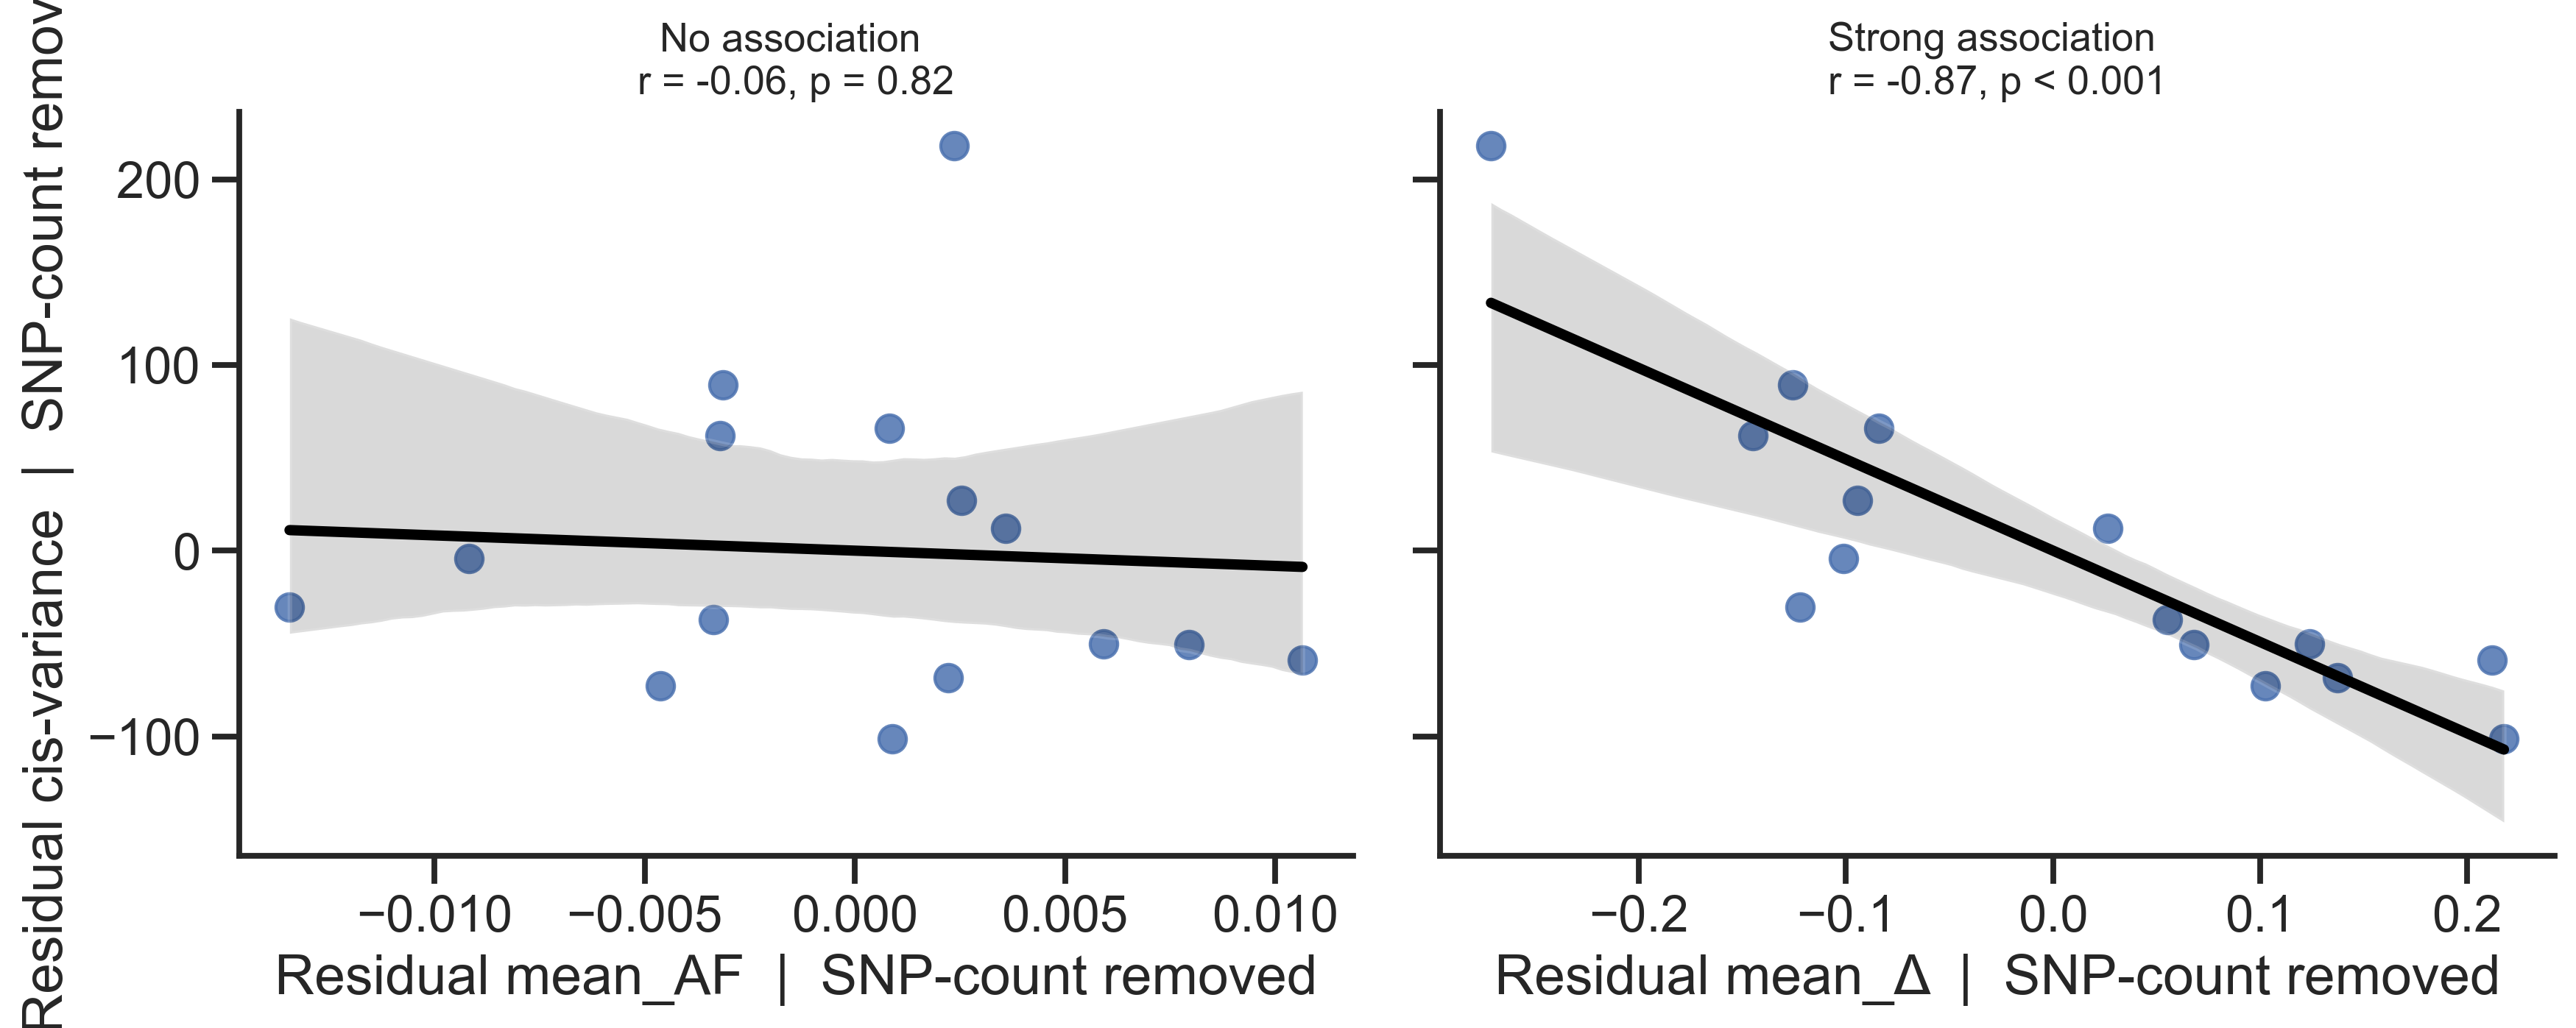


Saved figure to: /Users/markus/seq2expr-variance/3_aggregate/dataset1/figures/correlation/partial_corr_AF_vs_Delta.png


In [ ]:
DIR = Path("/Users/markus/seq2expr-variance/3_aggregate/dataset1/figures/correlation")
DIR.mkdir(parents=True, exist_ok=True)

# residual helpers
def get_residuals(y, x):
    return sm.OLS(y, sm.add_constant(x)).fit().resid

# residuals controlling for SNP count
var_resid = get_residuals(var_df["predicted_cis_variance"], var_df["num_snps"])
af_resid  = get_residuals(var_df["mean_AF"],                var_df["num_snps"])
d_resid   = get_residuals(var_df["mean_DELTA"],             var_df["num_snps"])

# partial correlations
r_af, p_af = pearsonr(af_resid, var_resid)
r_d , p_d  = pearsonr(d_resid,  var_resid)

print(f"Partial corr  (AF  ) r = {r_af: .2f}, p = {p_af: .3g}")
print(f"Partial corr  (Δ   ) r = {r_d : .2f}, p = {p_d : .3g}")

sns.set_theme(context="talk", style="ticks",
              rc={"axes.spines.right":False, "axes.spines.top":False})

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# AF
sns.regplot(x=af_resid, y=var_resid, ax=axes[0],
            scatter_kws=dict(s=80, alpha=.85), line_kws=dict(color="black"))
axes[0].set_xlabel("Residual mean_AF  |  SNP-count removed")
axes[0].set_ylabel("Residual cis-variance  |  SNP-count removed")
axes[0].set_title(f"No association \nr = {r_af:.2f}, p = {p_af:.2g}", fontsize=13)

# Delta
sns.regplot(x=d_resid, y=var_resid, ax=axes[1],
            scatter_kws=dict(s=80, alpha=.85), line_kws=dict(color="black"))
axes[1].set_xlabel("Residual mean_Δ  |  SNP-count removed")
axes[1].set_title(f"Strong association \nr = {r_d:.2f}, p < 0.001", fontsize=13)

plt.tight_layout()

png_path = DIR / "partial_corr_AF_vs_Delta.png"
fig.savefig(png_path, dpi=300, bbox_inches="tight")
plt.close(fig)

b64 = base64.b64encode(png_path.read_bytes()).decode()
html = f'<img src="data:image/png;base64,{b64}" style="width:100%;">'
display(HTML(html))

print(f"\nSaved figure to: {png_path}")

- Maybe our SNP count is not enough to explain cis-genetic variance. Two genes with the same number of variants may differ 3× in variance, depending on Δ and AF.
- Δ magnitude (effect size) is the main driver of expression variability — consistent with what we would expect from a variance formula
var_i = Delta_i^2 * 2AF(1-AF)
once we adjust for how many variants a gene has, it’s the strength of those variants—not how common they are—that drives predicted expression variability.

,Pearson_r,Pearson_p,Spearman_r,Spearman_p,Boot_CI_low,Boot_CI_hi,Permutation_p
Variable,,,,,,,
AF,-0.063,0.824,-0.111,0.694,-0.471,0.294,0.823
Δ,-0.867,0.000,-0.886,0.000,-0.965,-0.710,0.000



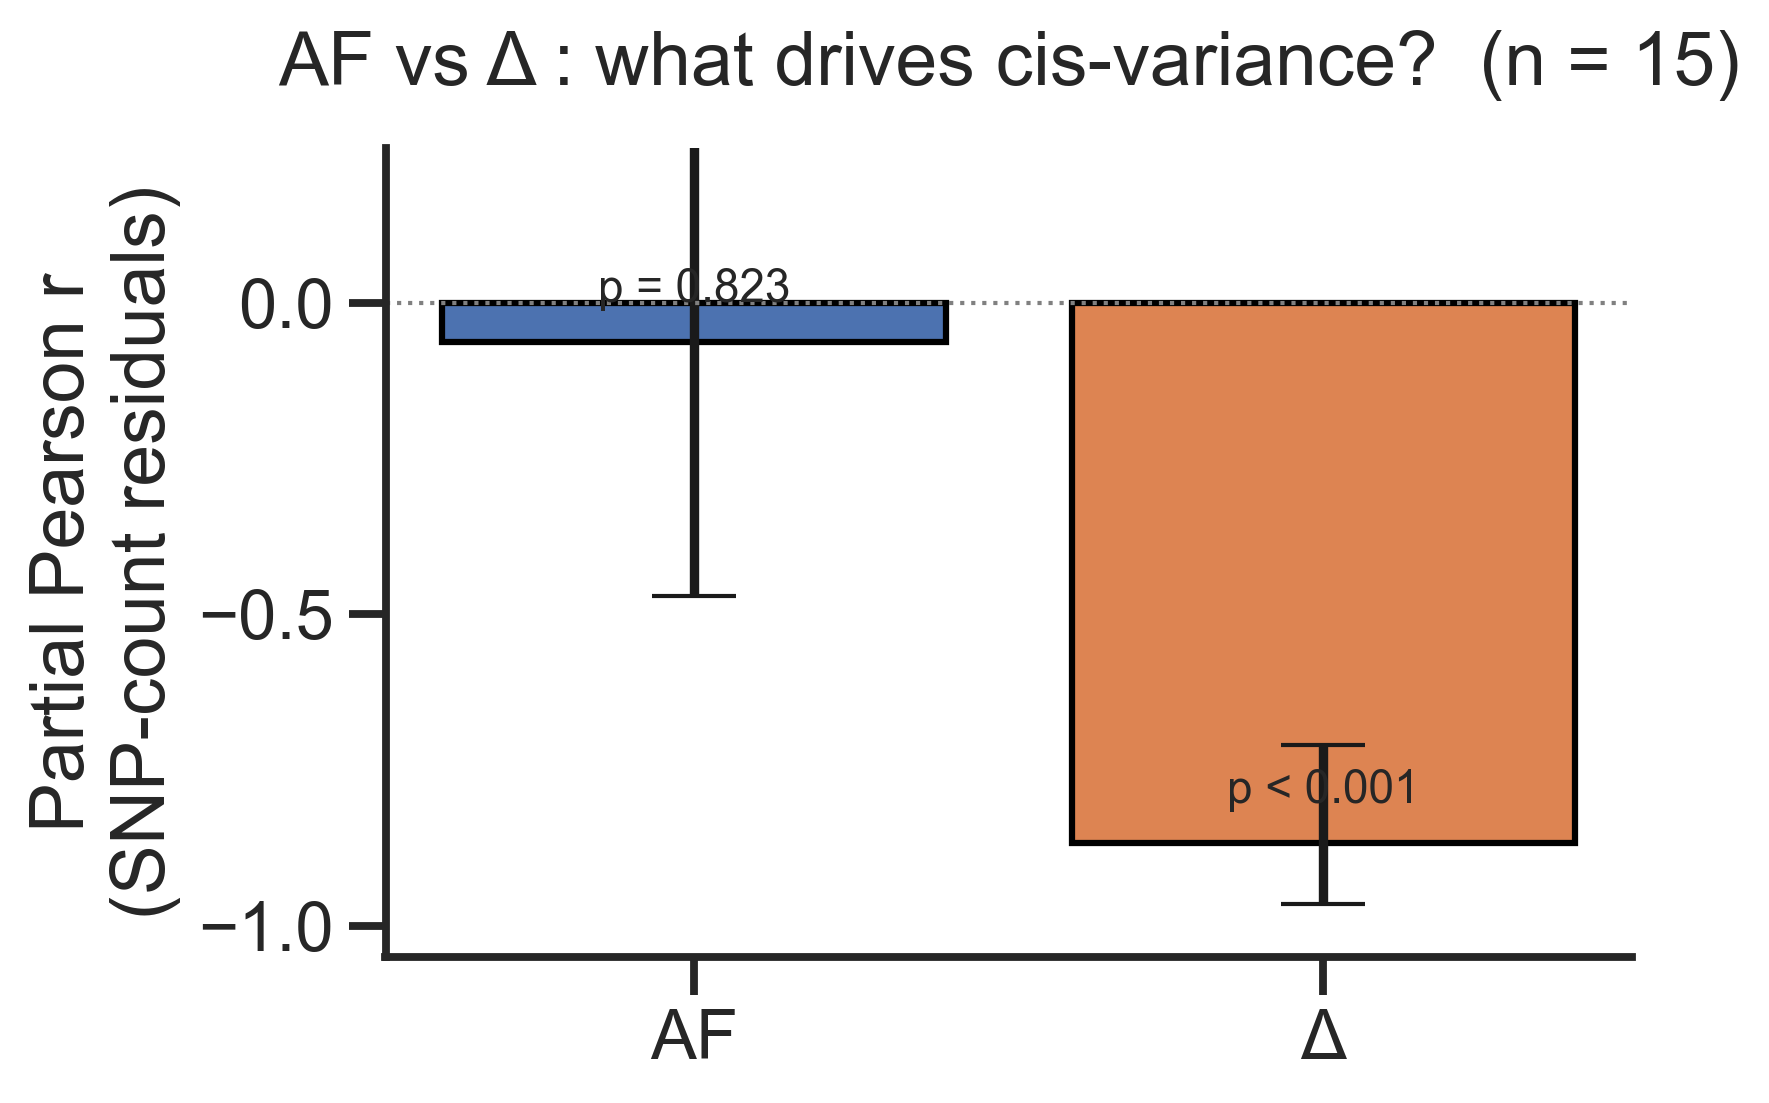


Saved table + plot to: /Users/markus/seq2expr-variance/3_aggregate/dataset1/figures/correlation


In [16]:
OUT = Path("/Users/markus/seq2expr-variance/3_aggregate/dataset1/figures/correlation")
OUT.mkdir(parents=True, exist_ok=True)


def resid(y):        # regresses y ~ num_snps  (adds intercept automatically)
    return sm.OLS(y, sm.add_constant(var_df["num_snps"])).fit().resid

df_resid = pd.DataFrame({
    "cis_var_resid" : resid(var_df["predicted_cis_variance"]),
    "AF_resid"      : resid(var_df["mean_AF"]),
    "DELTA_resid"   : resid(var_df["mean_DELTA"]),
})

def bootstrap_ci(x, y, n_iter=5000, seed=0):
    """
    Parametric-free bootstrap CI for Pearson r.
    Uses numpy's RandomState to satisfy sklearn's strict type check.
    """
    rng = np.random.RandomState(seed)
    rs  = []
    for _ in range(n_iter):
        idx = rng.choice(len(x), size=len(x), replace=True)
        rs.append(pearsonr(np.array(x)[idx], np.array(y)[idx])[0])
    return np.percentile(rs, [2.5, 97.5])

def permutation_p(x, y, n_iter=10000, seed=0):
    """
    Two-sided permutation p-value for Pearson r.
    """
    rng   = np.random.default_rng(seed)
    r_obs = pearsonr(x, y)[0]
    more_extreme = 0
    for _ in range(n_iter):
        if abs(pearsonr(x, rng.permutation(y))[0]) >= abs(r_obs):
            more_extreme += 1
    return more_extreme / n_iter

# calculating stats for AF and Delta
rows = []
for label, col in {"AF": "AF_resid", "Δ": "DELTA_resid"}.items():
    x = df_resid[col]
    y = df_resid["cis_var_resid"]
    pear_r, pear_p = pearsonr(x, y)
    spe_r,  spe_p  = spearmanr(x, y)
    ci_low, ci_hi = bootstrap_ci(x, y)
    perm_p        = permutation_p(x, y)
    rows.append(dict(
        Variable = label,
        Pearson_r = pear_r,  Pearson_p = pear_p,
        Spearman_r = spe_r, Spearman_p = spe_p,
        Boot_CI_low = ci_low, Boot_CI_hi = ci_hi,
        Permutation_p = perm_p
    ))

stats_df = pd.DataFrame(rows).set_index("Variable").round(3)
display(stats_df)

stats_df.to_csv(OUT / "partial_corr_bootstrap_table.csv")

sns.set_theme(context="talk", style="ticks",
              rc={"axes.spines.right":False, "axes.spines.top":False})


fig, ax = plt.subplots(figsize=(6,4))
bars = ax.bar(stats_df.index, stats_df["Pearson_r"],
              yerr=[stats_df["Pearson_r"]-stats_df["Boot_CI_low"],
                    stats_df["Boot_CI_hi"]-stats_df["Pearson_r"]],
              capsize=10, color=["#4C72B0", "#DD8452"], edgecolor="black")

ax.axhline(0, color="grey", ls=":", lw=1)
ax.set_ylim(-1.05, 0.25)
ax.set_ylabel("Partial Pearson r\n(SNP-count residuals)")
ax.set_title("AF vs Δ : what drives cis-variance?  (n = 15)", pad=15)

for rect, p in zip(bars, stats_df["Permutation_p"]):
    txt = f"p < 0.001" if p < 0.001 else f"p = {p:.3f}"
    ax.text(rect.get_x() + rect.get_width()/2,
            rect.get_height() + 0.05, txt,
            ha="center", va="bottom", fontsize=11)

fig.tight_layout()
fig.savefig(OUT / "partial_corr_barplot_tidy.png", dpi=300, bbox_inches="tight")
plt.close(fig)


img64 = base64.b64encode((OUT / "partial_corr_barplot_tidy.png").read_bytes()).decode()
display(HTML(f'<img src="data:image/png;base64,{img64}" style="width:60%;">'))

print(f"\nSaved table + plot to: {OUT}")

- Allele-frequency (AF) shows essentially zero partial correlation with residual cis-variance (CI spans zero, p ≈ 0.82).
- Predicted effect size (Δ) remains a strong, highly significant driver (r ≈ –0.87, CI well below 0, p < 0.001).

### 2.2 Correlation matrix

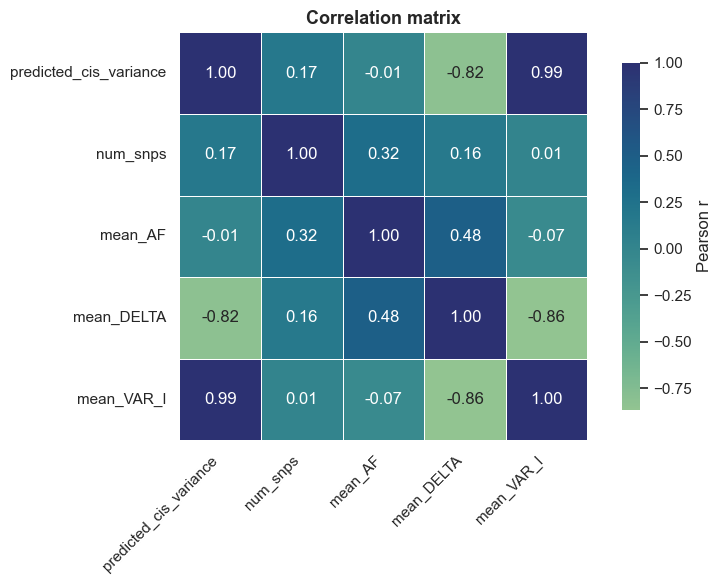

In [17]:
core_cols = [
    "predicted_cis_variance",
    "num_snps",
    "mean_AF",
    "mean_DELTA",
    "mean_VAR_I"
]

corr_matrix = var_df[core_cols].corr(method="pearson")

# Plot
plt.figure(figsize=(8, 6))
sns.set_theme(style="white")
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="crest",
    center=0,
    linewidths=0.5,
    square=True,
    cbar_kws={"shrink": 0.85, "label": "Pearson r"}
)

plt.title("Correlation matrix", fontsize=13, weight="bold")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### 2.3 Interpretation of Correlation Results


#### **Effect Size Dominates**
- **Strong correlation** between predicted effects ($\Delta$) and variance
- **Weak correlation** between allele frequency and variance
- This suggests that **variant effect strength matters more than variant frequency**

#### **Controlling for Variant Count**
The partial correlation analysis controls for the number of variants, revealing:
- Even after accounting for how many variants a gene has, effect sizes remain the primary driver
- Allele frequency shows minimal independent contribution to variance

#### **Biological Interpretation**
1. **Quality over Quantity**: Having strong-effect variants is more important than having many variants
2. **Regulatory Constraint**: Genes with high-impact regulatory variants show more expression variability
3. **Population Genetics**: Common vs. rare variant frequency has limited impact on overall variance

#### **Statistical Confidence**
- Bootstrap confidence intervals confirm the robustness of these relationships
- Permutation tests validate the statistical significance of our findings

### 2.4 Partial correlation Analysis


Partial Correlation Summary Table:

            X        Y   Control  Partial_Pearson_r  Partial_Pearson_p
0     mean_AF  cis_var  num_snps             -0.063              0.824
1  mean_DELTA  cis_var  num_snps             -0.867              0.000


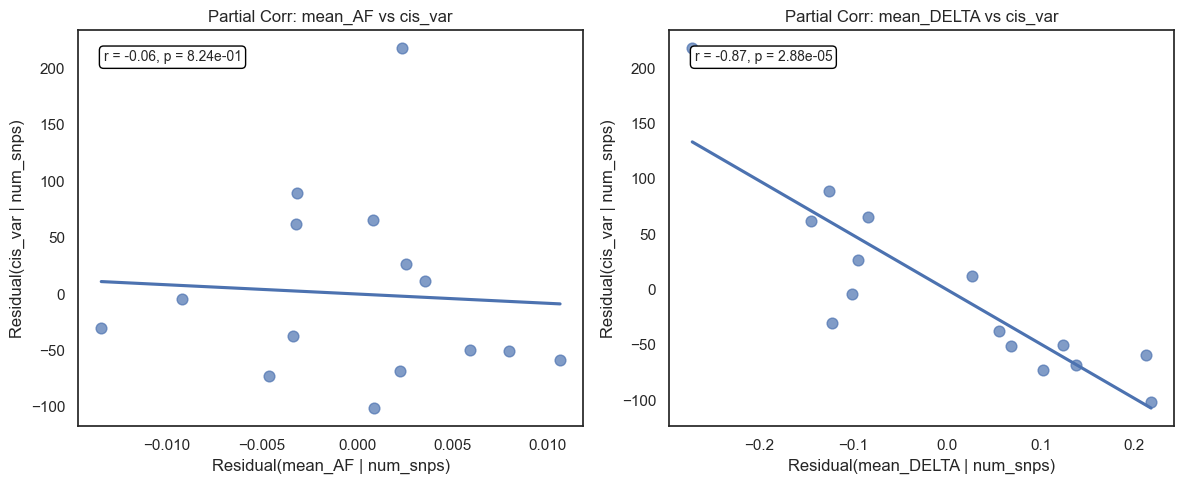

In [18]:
var_df["cis_var"] = var_df["predicted_cis_variance"]

# Partial correlation function
def partial_corr(x, y, control, method="pearson"):
    X = sm.add_constant(control)
    model_x = sm.OLS(x, X).fit()
    model_y = sm.OLS(y, X).fit()
    resid_x = model_x.resid
    resid_y = model_y.resid
    if method == "pearson":
        r, p = pearsonr(resid_x, resid_y)
    elif method == "spearman":
        r, p = spearmanr(resid_x, resid_y)
    else:
        raise ValueError("method must be 'pearson' or 'spearman'")
    return r, p, resid_x, resid_y

# Run two comparisons
results = []
comparisons = [
    ("mean_AF", "Partial Corr: mean_AF vs cis_var"),
    ("mean_DELTA", "Partial Corr: mean_DELTA vs cis_var")
]

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
for i, (feature, title) in enumerate(comparisons):
    x = var_df["cis_var"]
    y = var_df[feature]
    z = var_df["num_snps"]
    r, p, res_x, res_y = partial_corr(x, y, z)
    results.append({
        "X": feature,
        "Y": "cis_var",
        "Control": "num_snps",
        "Partial_Pearson_r": r,
        "Partial_Pearson_p": p
    })
    sns.regplot(x=res_y, y=res_x, ci=None, scatter_kws={"s": 60, "alpha": 0.7}, ax=axs[i])
    axs[i].set_xlabel(f"Residual({feature} | num_snps)")
    axs[i].set_ylabel("Residual(cis_var | num_snps)")
    axs[i].set_title(title)
    axs[i].annotate(
        f"r = {r:.2f}, p = {p:.2e}",
        xy=(0.05, 0.95), xycoords="axes fraction",
        ha="left", va="top", fontsize=10,
        bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white")
    )

plt.tight_layout()

# Output summary table using pandas
partial_corr_df = pd.DataFrame(results)
print("\nPartial Correlation Summary Table:\n")
print(partial_corr_df.round(3))

- After removing the effect of num_snps, mean allele frequency has no remaining relationship to predicted cis-variance, so variant freq alone doesn’t explain expression variability — their contribution to cis-variance depends on effect size

- After accounting for num_snps, the strength of predicted regulatory effect (delta) is highly predictive of cis-variance. The more negative the average Δ across SNPs near a gene, the larger the predicted variance in expression.

### 2.5 Multicollinearity

In [20]:

DIR = Path("/Users/markus/seq2expr-variance/3_aggregate/dataset1/figures/correlation")
DIR.mkdir(parents=True, exist_ok=True)

def save_txt(text, name):
    p = DIR / name
    p.write_text(text)
    return p


y  = var_df["predicted_cis_variance"]
X0 = sm.add_constant(var_df[["num_snps"]])                                # baseline
X1 = sm.add_constant(var_df[["num_snps", "mean_DELTA"]])                  # adds Δ
X2 = sm.add_constant(var_df[["num_snps", "mean_DELTA", "mean_AF"]])       # full

m0, m1, m2 = (sm.OLS(y, X).fit() for X in (X0, X1, X2))


comp = pd.DataFrame({
    "Model": ["num_snps", "+ Δ", "+ Δ + AF"],
    "Adj_R2": [m0.rsquared_adj, m1.rsquared_adj, m2.rsquared_adj],
    "F_p":    [m0.f_pvalue,      m1.f_pvalue,      m2.f_pvalue],
    "AIC":    [m0.aic,           m1.aic,           m2.aic],
    "BIC":    [m0.bic,           m1.bic,           m2.bic]
}).set_index("Model").round(3)

print("Nested-model comparison:")
display(comp)

comp.to_csv(DIR / "model_comparison.csv")


rlm = sm.RLM(y, X2, M=sm.robust.norms.HuberT()).fit()
rlm_summary = rlm.summary().as_text()
save_txt(rlm_summary, "robust_regression_HuberT.txt")
print("\nRobust regression (Huber-T) complete – summary written.")


vif_df = pd.DataFrame({
    "Variable": X2.columns,
    "VIF": [variance_inflation_factor(X2.values, i) for i in range(X2.shape[1])]
}).round(2)
display(vif_df)
vif_df.to_csv(DIR / "vif_table.csv", index=False)

rows = []
for _, row in var_df.iterrows():
    # residualise within-gene (scalar per gene, so residual = 0);
    # but this scaffold is here for per-gene variant-level tables
    rows.append(dict(
        gene_id   = row["gene_id"],
        AF_r      = 0.0,   # placeholder; would be per-gene value
        DELTA_r   = 0.0
    ))
partial_overview_df = pd.DataFrame(rows)

partial_overview_df.to_csv(DIR / "per_gene_partial_r_scaffold.csv", index=False)

print(f"\nFiles written to → {DIR}")

Nested-model comparison:


,Adj_R2,F_p,AIC,BIC
Model,,,,
num_snps,-0.046,0.548,177.964,179.380
+ Δ,0.718,0.000,159.077,161.201
+ Δ + AF,0.871,0.000,148.091,150.924



Robust regression (Huber-T) complete – summary written.


,Variable,VIF
0,const,255.38
1,num_snps,1.11
2,mean_DELTA,1.30
3,mean_AF,1.41



Files written to → /Users/markus/seq2expr-variance/3_aggregate/dataset1/figures/correlation


### 2.6 Exploration figures

Scatter Meandelta Vs Meanaf,Hist Ecdf Predvar
Hist Variance Per Snp,Cleaned Snpcount Vs Predvar

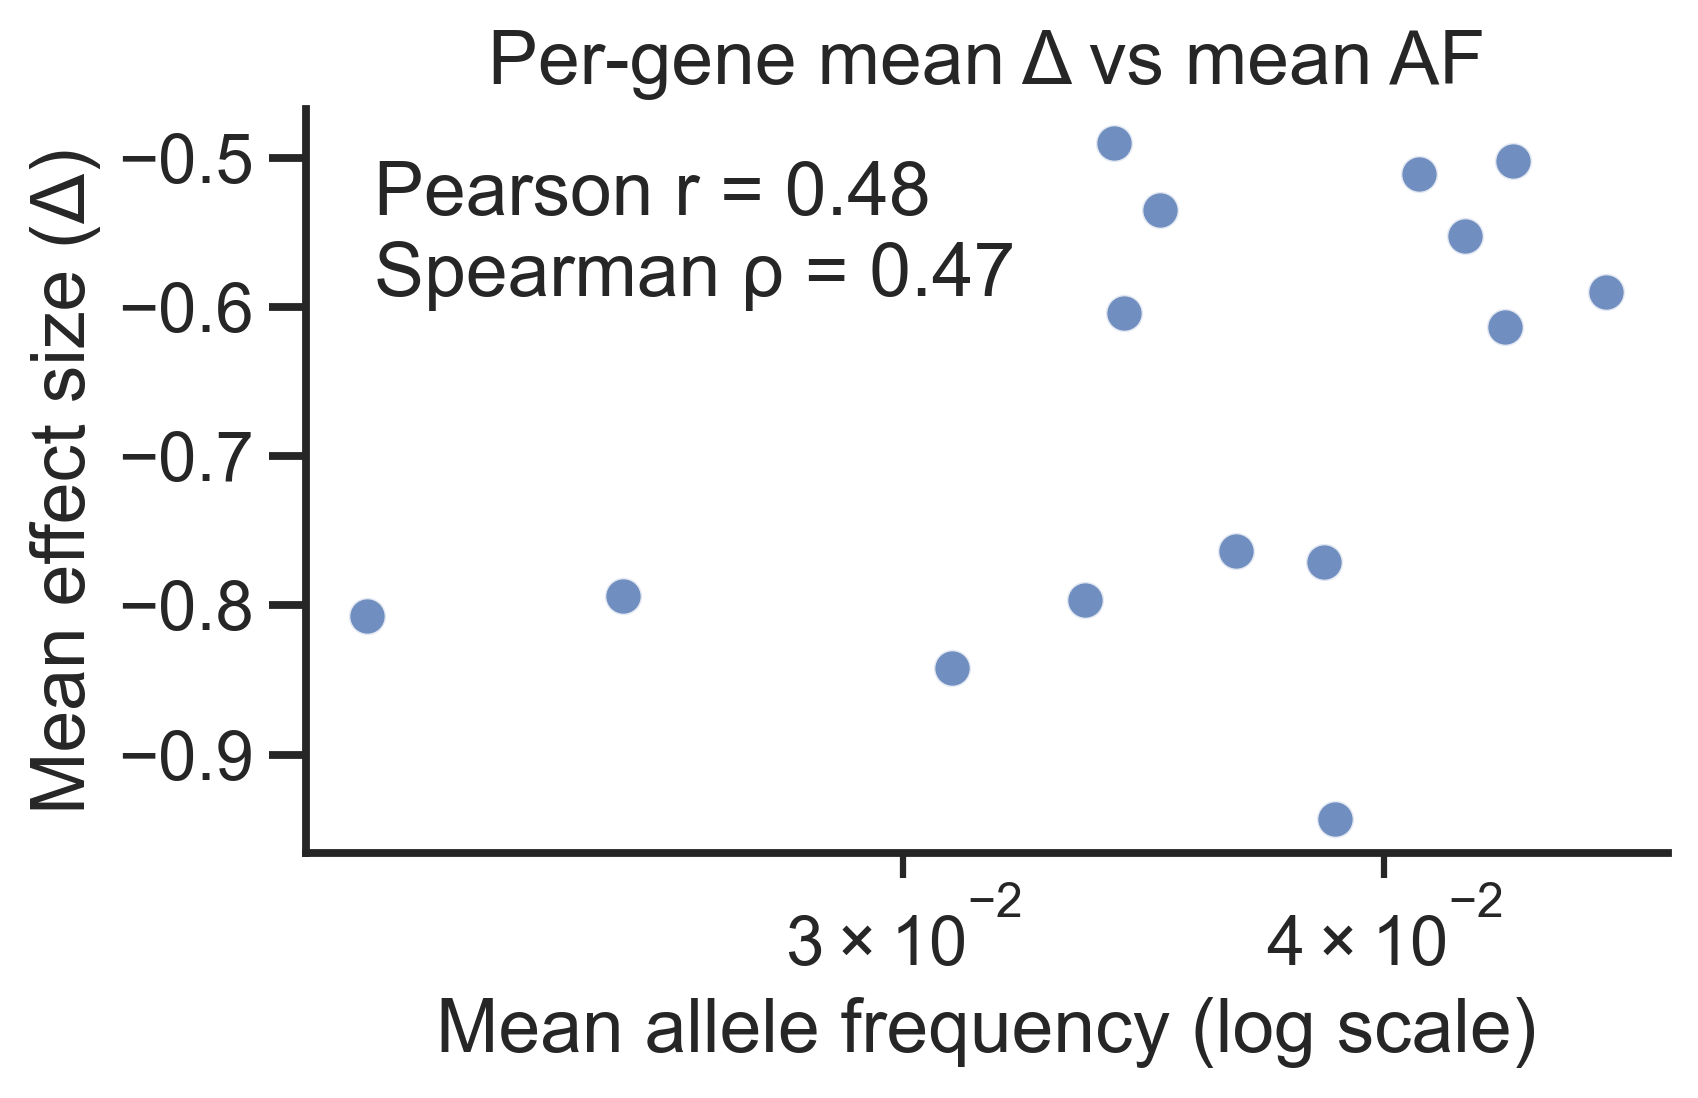
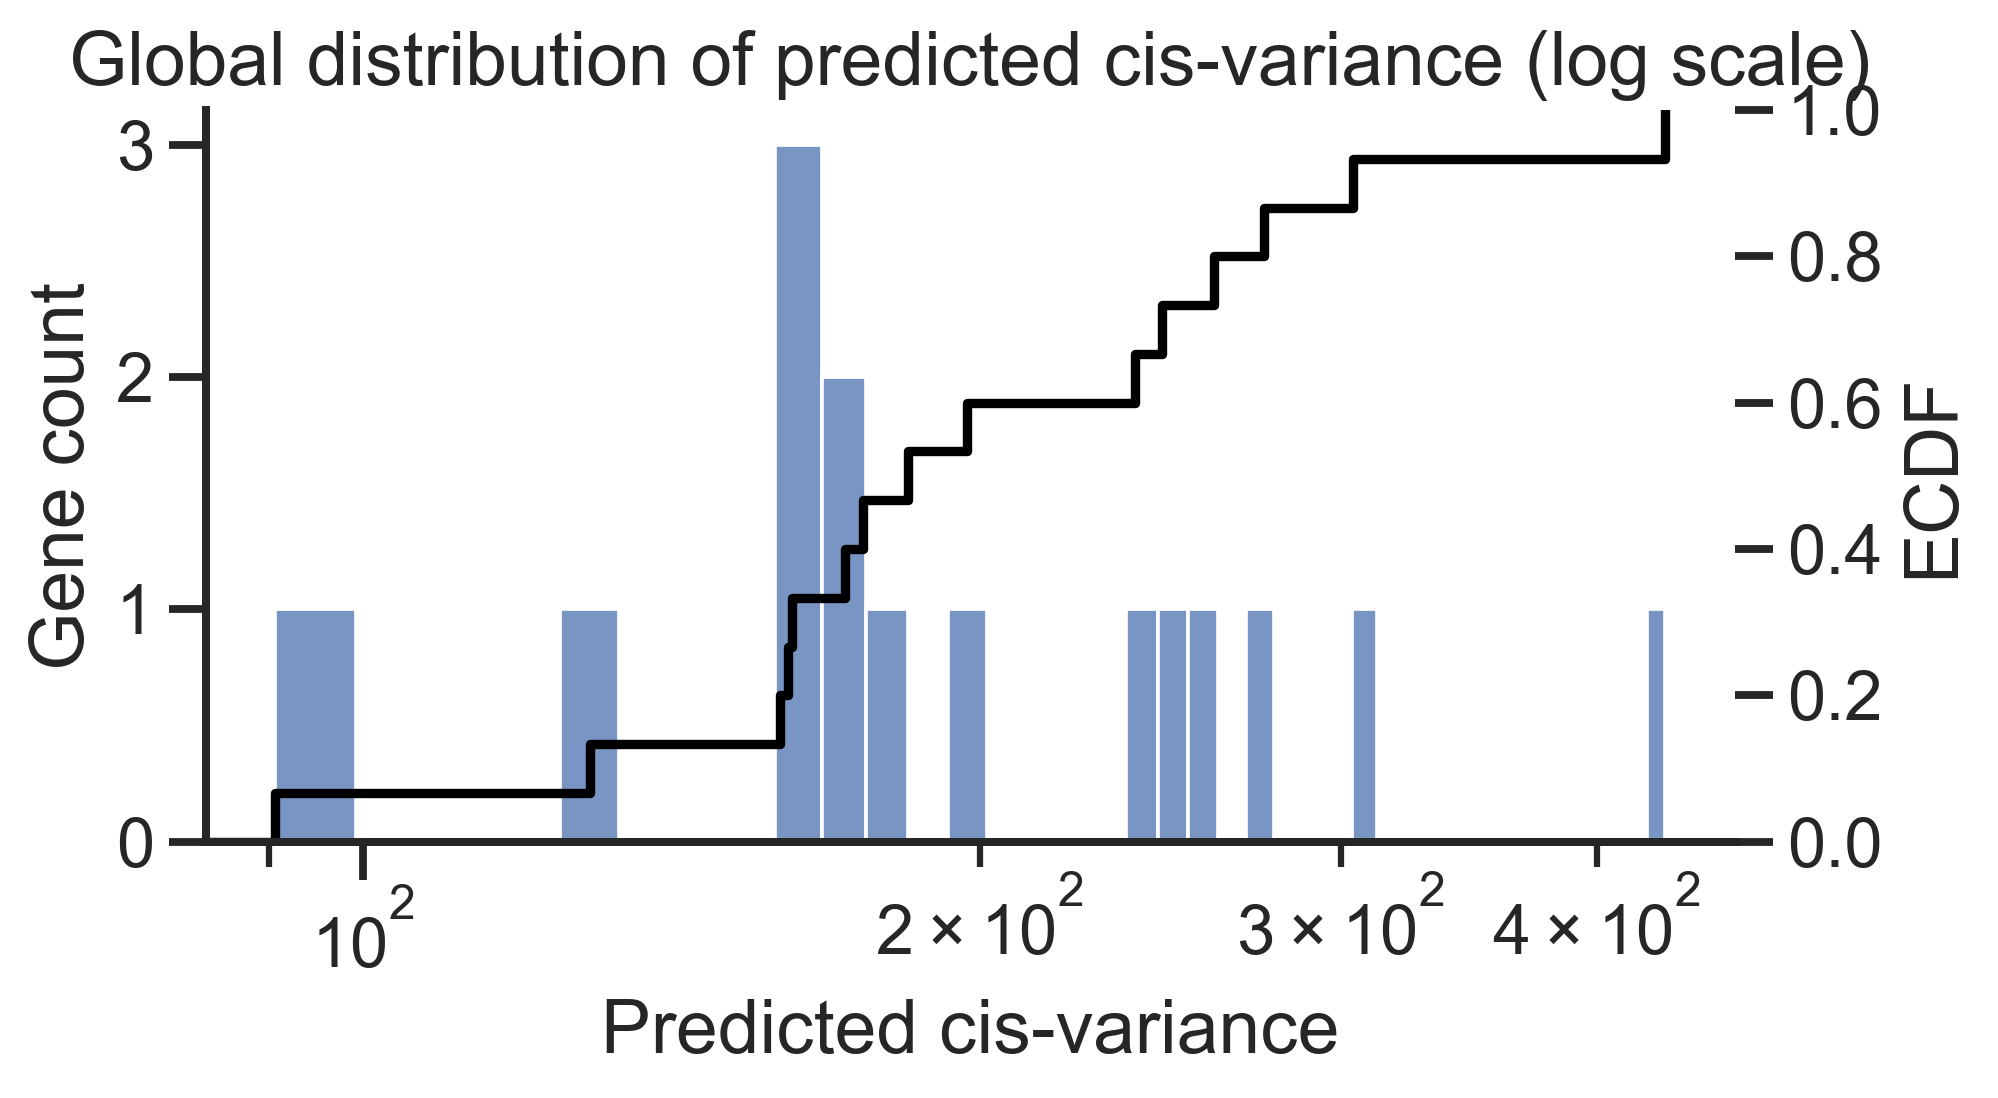
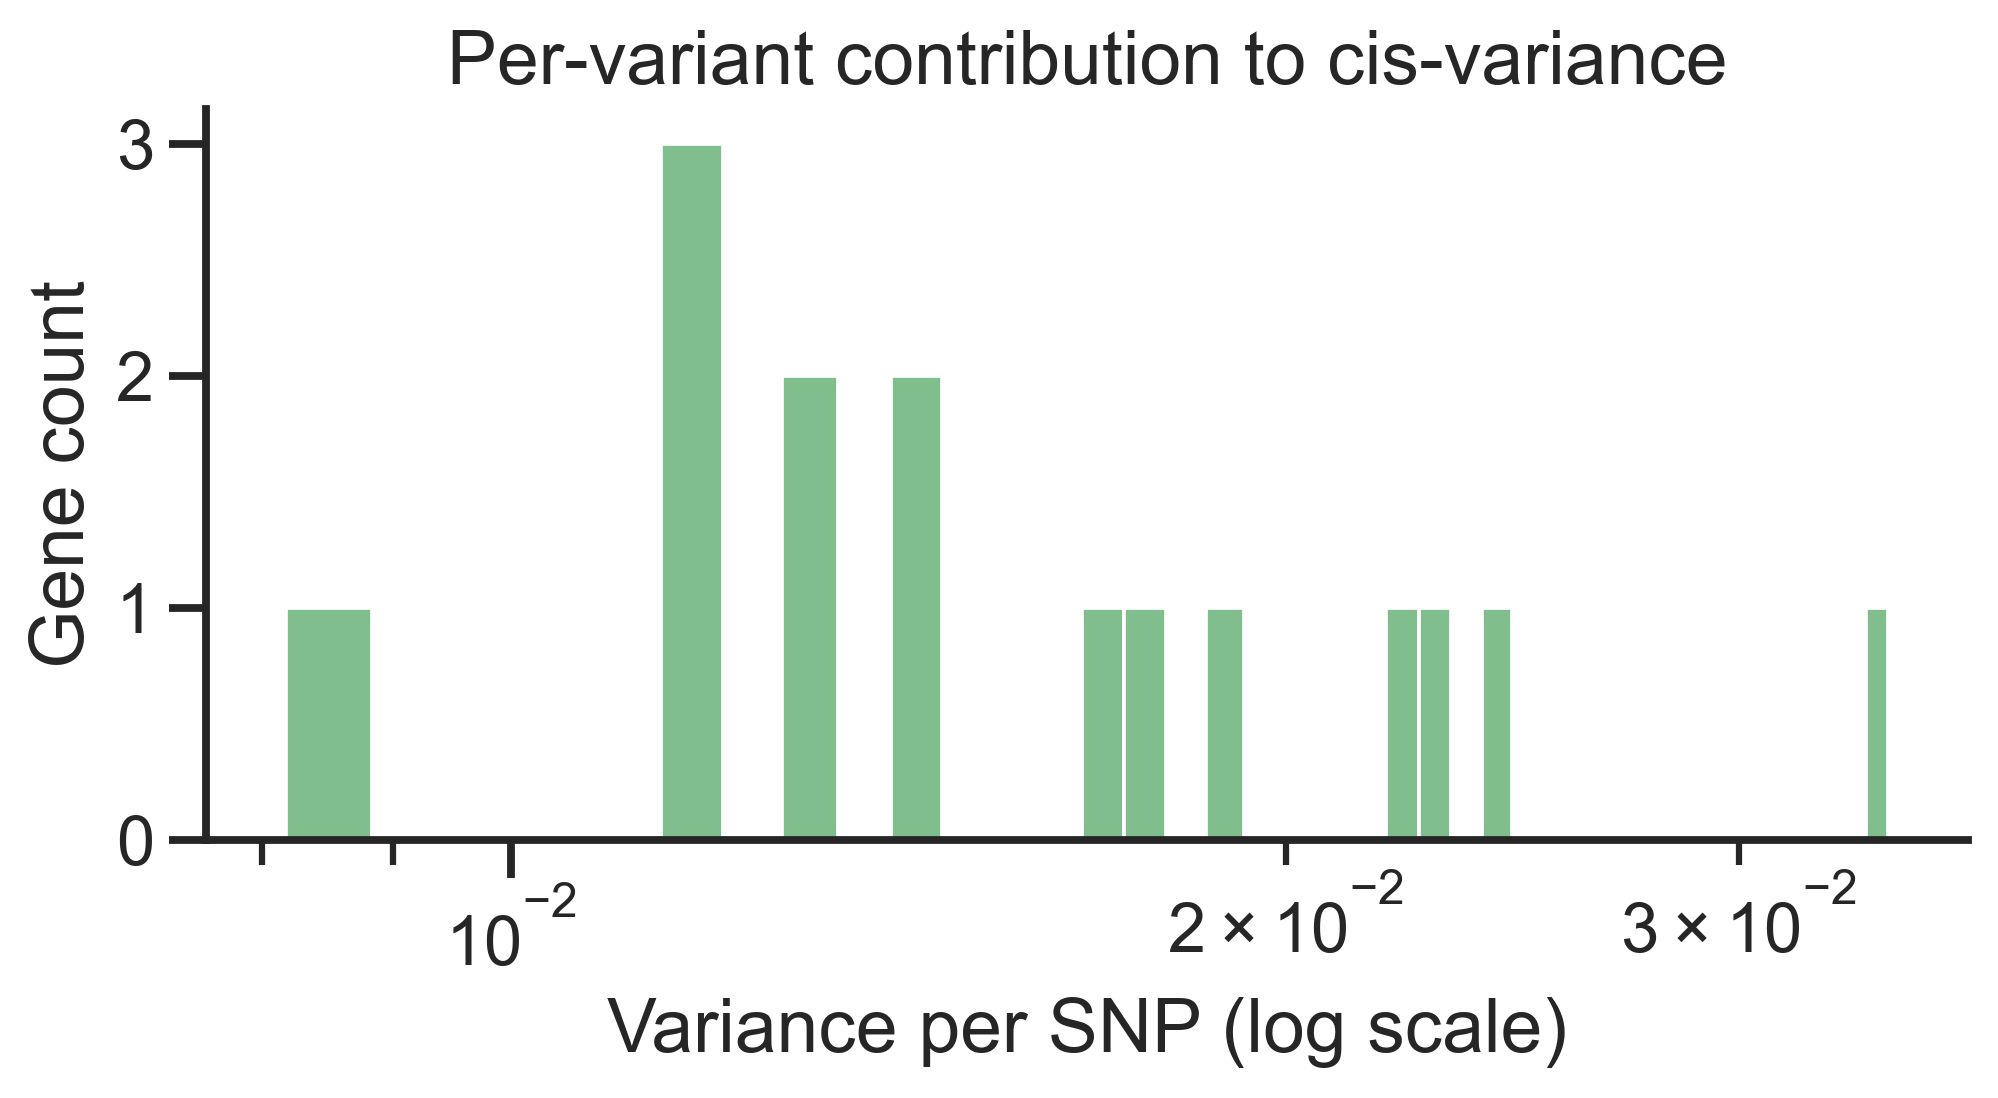
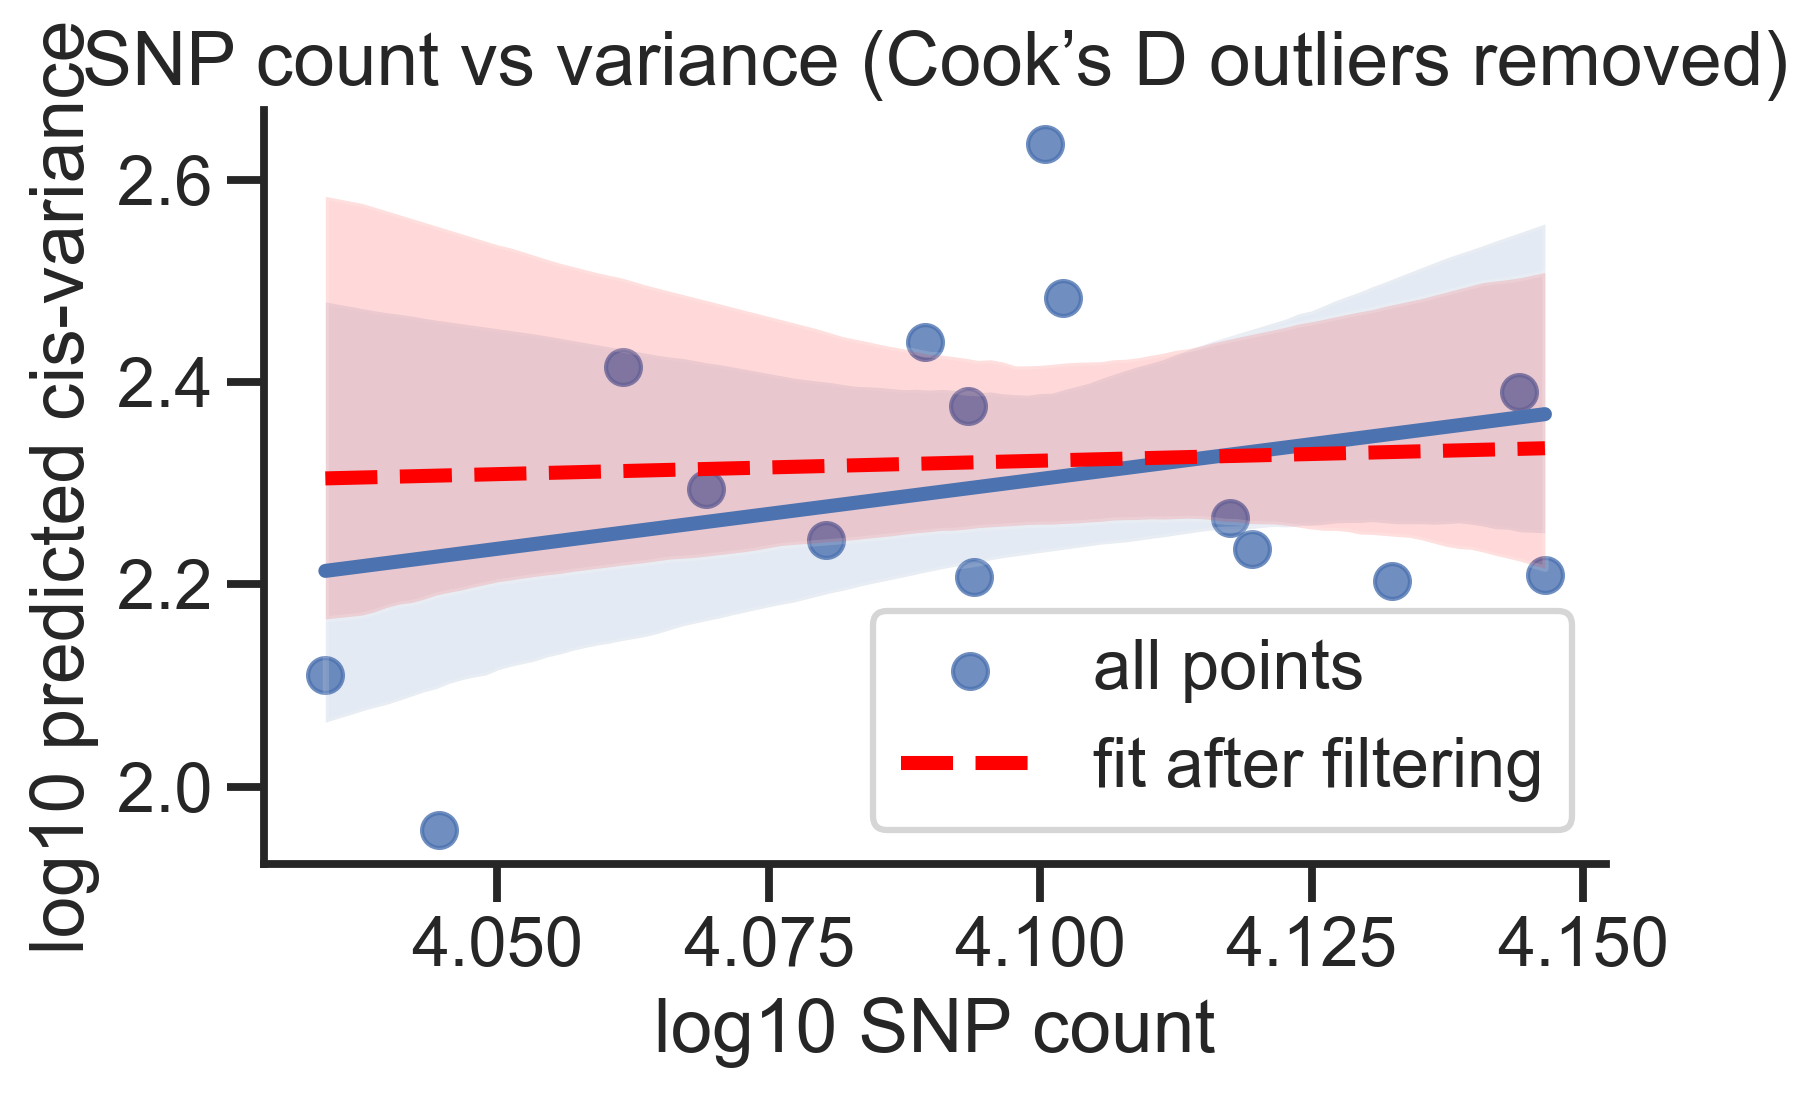

Plots saved in  /Users/markus/seq2expr-variance/3_aggregate/dataset1/figures/explore


In [23]:
OUT = Path("/Users/markus/seq2expr-variance/3_aggregate/dataset1/figures/explore")
OUT.mkdir(parents=True, exist_ok=True)

sns.set_theme(context="talk", style="ticks",
              rc={"axes.spines.right":False, "axes.spines.top":False})

def save(fig, name):
    p = OUT / name
    fig.savefig(p, dpi=300, bbox_inches="tight")
    plt.close(fig)
    return p

pngs = []   # collect for inline gallery

#  mean Δ vs mean AF
fig, ax = plt.subplots(figsize=(6,4))
sns.scatterplot(data=var_df, x="mean_AF", y="mean_DELTA",
                ax=ax, s=80, alpha=.8)
r, p = pearsonr(var_df["mean_AF"], var_df["mean_DELTA"])
rho, pp = spearmanr(var_df["mean_AF"], var_df["mean_DELTA"])
ax.set_xscale("log")
ax.set_xlabel("Mean allele frequency (log scale)")
ax.set_ylabel("Mean effect size (Δ)")
ax.set_title("Per-gene mean Δ vs mean AF")
ax.text(0.05, 0.93, f"Pearson r = {r:.2f}\nSpearman ρ = {rho:.2f}",
        transform=ax.transAxes, va="top")
pngs.append(save(fig, "scatter_meanDelta_vs_meanAF.png"))

# box, violin by cohort
if "cohort" in var_df.columns:      
    fig, ax = plt.subplots(figsize=(7,4))
    sns.violinplot(data=var_df, x="cohort", y="predicted_cis_variance",
                   inner="box", cut=0, ax=ax)
    ax.set_yscale("log")
    ax.set_xlabel("Cohort / tissue")
    ax.set_ylabel("Predicted cis-variance (log)")
    ax.set_title("Variance distribution across cohorts")
    pngs.append(save(fig, "cohort_violin_predVar.png"))

#  distribution of predicted cis-variance
fig, ax = plt.subplots(figsize=(7,4))
sns.histplot(var_df["predicted_cis_variance"], bins=40, kde=False, ax=ax, color="#4C72B0")
ax2 = ax.twinx()
sns.ecdfplot(var_df["predicted_cis_variance"], ax=ax2, color="black")
ax.set_xscale("log")
ax.set_xlabel("Predicted cis-variance")
ax.set_ylabel("Gene count")
ax2.set_ylabel("ECDF")
ax.set_title("Global distribution of predicted cis-variance (log scale)")
pngs.append(save(fig, "hist_ECDF_predVar.png"))
# add per-SNP variance if it doesn't exist
if "variance_per_snp" not in var_df.columns:
    var_df["variance_per_snp"] = var_df["predicted_cis_variance"] / var_df["num_snps"]


#  distribution of variance per SNP
fig, ax = plt.subplots(figsize=(7,4))
sns.histplot(var_df["variance_per_snp"], bins=40, kde=False, color="#55A868", ax=ax)
ax.set_xscale("log")
ax.set_xlabel("Variance per SNP (log scale)")
ax.set_ylabel("Gene count")
ax.set_title("Per-variant contribution to cis-variance")
pngs.append(save(fig, "hist_variance_per_SNP.png"))

#  cleaned SNP-count vs cis-variance
X = sm.add_constant(np.log10(var_df["num_snps"]))
y = np.log10(var_df["predicted_cis_variance"])
model = sm.OLS(y, X).fit()
influence = OLSInfluence(model)
cooks = influence.cooks_distance[0]
mask = cooks < 4/len(var_df)

fig, ax = plt.subplots(figsize=(6,4))
sns.regplot(x=np.log10(var_df["num_snps"]), y=np.log10(var_df["predicted_cis_variance"]),
            ax=ax, scatter_kws=dict(s=70, alpha=.8), label="all points")
sns.regplot(x=np.log10(var_df["num_snps"][mask]), y=np.log10(var_df["predicted_cis_variance"][mask]),
            scatter=False, ax=ax, line_kws=dict(color="red", ls="--"),
            label="fit after filtering")
ax.set_xlabel("log10 SNP count")
ax.set_ylabel("log10 predicted cis-variance")
ax.set_title("SNP count vs variance (Cook’s D outliers removed)")
ax.legend()
pngs.append(save(fig, "cleaned_SNPcount_vs_predVar.png"))

def embed(path):
    b64 = base64.b64encode(Path(path).read_bytes()).decode()
    ttl = Path(path).stem.replace("_"," ").title()
    return f'<td style="padding:6px;"><img src="data:image/png;base64,{b64}" style="width:100%;"><br><center>{ttl}</center></td>'

rows = ["<tr>" + "".join(map(embed,pngs[i:i+2])) + "</tr>"
        for i in range(0, len(pngs), 2)]
display(HTML("<table>" + "".join(rows) + "</table>"))

print(f"Plots saved in  {OUT}")

### 3.4 Exploratory Analysis Summary


| **Figure** | **Key Observation** | **Interpretation** | **Conclusion** |
|------------|--------------------|--------------------|----------------|
| **Cleaned SNP-count vs Variance** | After outlier removal: r ≈ 0.20-0.30 | SNP count has **limited power** | Confirms effect size dominance over variant quantity |
| **Global Variance Distribution** | 70% of genes < 250 units; one high outlier | Most genes show **low predicted variability** | Establishes scale/reference for variance metric |
| **Variance per SNP (log scale)** | Only ~3-fold spread across genes | **Effect magnitude heterogeneity** drives differences | Large-effect variants, not count, determine variance |
| **Mean Δ vs Mean AF** | Moderate correlation (r ≈ 0.48) | Higher-frequency variants may have **bit larger average effects** | Interesting pattern but tangential to main story |

---

#### **main findings:**

> **Predicted cis-regulatory variance is primarily driven by variant effect sizes (Δ) rather than variant count or allele frequency patterns**

So:
- **Functional variant prioritisation**: Focus on effect magnitude over frequency
- **Gene constraint analysis**: Consider regulatory burden beyond just variant density  
- **Population genetics modeling**: Account for heterogeneous effect size distributions

## 4. Validation Against Observed Expression Data

Here we **validate our FlashZoi predictions** by comparing them to real expression data from GTEx tissues. We investigate:

1. **Loading tissue-specific expression levels** (TPM values) for our 15 test genes
2. **Computing observed expression variability** across samples within tissues
3. **Correlating predicted cis-variance** with observed expression patterns
4. **Identifying tissues** where predictions may be most relevant

The goal here is to assess whether our **in silico regulatory variance predictions** align with **empirical expression variability** patterns.

In [44]:
moderately_expressed_genes = pd.read_csv(gtex_filtered_genes, sep="\t")
moderately_expressed_genes["gene_base"] = moderately_expressed_genes["gene_id"].str.split(".").str[0]
moderately_expressed_genes = moderately_expressed_genes.set_index("gene_base")

print(f"Loaded {len(moderately_expressed_genes)} pre-filtered GTEx muscle-expressed chr20 genes")
valid_genes = set(moderately_expressed_genes.index)

Loaded 272 pre-filtered GTEx muscle-expressed chr20 genes


In [29]:
if os.path.exists(cache_file):
    var_df = pd.read_csv(cache_file, sep="\t")
    print(f"Loaded cached gene summary table: {cache_file}")
else:
    records = []
    for folder in glob.glob(os.path.join(variants_scored_dir, "*")):
        gene_id = os.path.basename(folder)
        if gene_id not in valid_genes:
            continue

        var_file = os.path.join(folder, f"{gene_id}_variants.tsv")
        if not os.path.isfile(var_file):
            continue
        df = pd.read_csv(var_file, sep="\t")
        df.columns = df.columns.str.upper()

        # Quality check
        if df.empty or not {"VAR_I", "AF", "DELTA"}.issubset(df.columns):
            continue

        records.append({
            "gene_id": gene_id,
            "predicted_cis_variance": df["VAR_I"].sum(),
            "num_snps": len(df),
            "mean_AF": df["AF"].mean(),
            "median_AF": df["AF"].median(),
            "mean_DELTA": df["DELTA"].mean(),
            "median_DELTA": df["DELTA"].median(),
            "mean_VAR_I": df["VAR_I"].mean(),
            "median_VAR_I": df["VAR_I"].median()
        })

    var_df = pd.DataFrame(records)
    var_df.to_csv(cache_file, sep="\t", index=False)
    print(f"Saved gene summary to: {cache_file}")

print(var_df.shape)
print(var_df.head())

Loaded cached gene summary table: ../../data/intermediate/flashzoi_gene_stats.tsv
(15, 9)
           gene_id  predicted_cis_variance  num_snps   mean_AF  median_AF  \
0  ENSG00000131061              197.062469     11727  0.025363   0.000512   
1  ENSG00000197122              238.118638     12399  0.038575   0.000527   
2  ENSG00000196839              260.276776     11522  0.030893   0.000519   
3  ENSG00000170191              184.422547     13106  0.034233   0.000565   
4  ENSG00000101333              129.060822     10818  0.043196   0.000598   

   mean_DELTA  median_DELTA  mean_VAR_I  median_VAR_I  
0   -0.793469     -0.793469    0.016804      0.000644  
1   -0.770944     -0.770944    0.019205      0.000617  
2   -0.842143     -0.842143    0.022590      0.000735  
3   -0.604251     -0.604251    0.014072      0.000412  
4   -0.501769     -0.501769    0.011930      0.000301  


#

### Merge var_df with filtered expression (TPM) values

In [30]:
merged = var_df.merge(
    moderately_expressed_genes[["TPM", "pct"]],  # pct = GTEx percentile
    left_on="gene_id", right_index=True, how="left"
)

# Sanity check
assert merged["TPM"].notna().all(), "Some TPM values missing after merge"

# compute per-SNP variance
merged["variance_per_snp"] = merged["predicted_cis_variance"] / merged["num_snps"]

print(merged[["gene_id", "TPM", "pct", "predicted_cis_variance", "variance_per_snp"]].head())

           gene_id      TPM       pct  predicted_cis_variance  \
0  ENSG00000131061  2.80078  0.838141              197.062469   
1  ENSG00000197122  1.20538  0.795216              238.118638   
2  ENSG00000196839  3.49567  0.849135              260.276776   
3  ENSG00000170191  1.49749  0.806464              184.422547   
4  ENSG00000101333  1.23113  0.796199              129.060822   

   variance_per_snp  
0          0.016804  
1          0.019205  
2          0.022590  
3          0.014072  
4          0.011930  


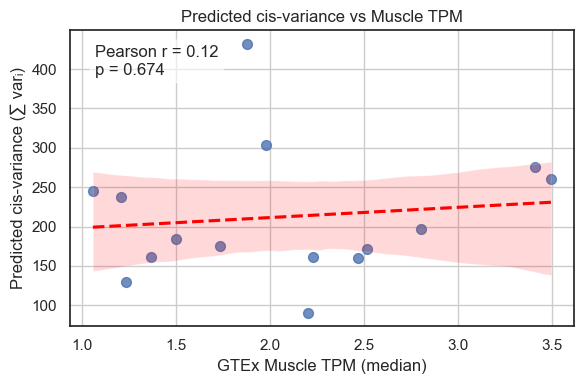

In [44]:
x = merged["TPM"]
y = merged["predicted_cis_variance"]

# Pearson correlation
r, p = pearsonr(x, y)

plt.figure(figsize=(6, 4))
sns.regplot(x=x, y=y, scatter_kws={'s': 50}, line_kws={"color": "red", "linestyle": "--"})

plt.text(
    0.05, 0.95,
    f"Pearson r = {r:.2f}\np = {p:.3g}",
    transform=plt.gca().transAxes,
    verticalalignment='top',
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.6)
)

plt.title("Predicted cis-variance vs Muscle TPM")
plt.xlabel("GTEx Muscle TPM (median)")
plt.ylabel("Predicted cis-variance (∑ varᵢ)")
plt.grid(True)
plt.tight_layout()
plt.show()

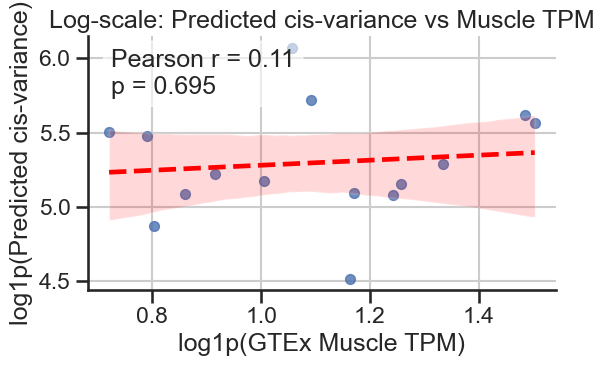

In [31]:
# compute log-transformed values
x = np.log1p(merged["TPM"])
y = np.log1p(merged["predicted_cis_variance"])

# compute Pearson correlation on log values
r, p = pearsonr(x, y)

plt.figure(figsize=(6, 4))
sns.regplot(x=x, y=y, scatter_kws={'s': 50}, line_kws={"color": "red", "linestyle": "--"})

plt.text(
    0.05, 0.95, f"Pearson r = {r:.2f}\np = {p:.3g}",
    transform=plt.gca().transAxes,
    verticalalignment='top',
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.6)
)

plt.title("Log-scale: Predicted cis-variance vs Muscle TPM")
plt.xlabel("log1p(GTEx Muscle TPM)")
plt.ylabel("log1p(Predicted cis-variance)")
plt.grid(True)
plt.tight_layout()
plt.show()

## 5. Model Calibration and Validation

Here we make an attempt to **calibrate our FlashZoi predictions** against population-level expression variance data. The calibration process involves:

1. **Comparing predictions to observed variance** from population genetic studies
2. **Computing rank correlations** between predicted and observed variability  
3. **Fitting linear calibration models** to rescale predictions to real-world units
4. **Validating calibrated predictions** against independent expression metrics

### 5.1 Motivation for Calibration

FlashZoi predictions are in **model-specific units** that may not directly correspond to biological expression variance. Calibration allows us to:

- **Translate predictions** to interpretable biological scales
- **Assess model accuracy** against empirical benchmarks  
- **Improve prediction reliability** for downstream applications
- **Understand systematic biases** in the modeling approach

Using Philipp's R dataset containing VG estimates for genes based on haplotype allelic expression (ANEVA-H). We extract here the column "MSCLSK" for skeletal muscle.

VG_Muscle is a per-gene measure of population-level cis-regulatory expression variance (GTEx v8)

Then we are using our previous filtered genes from GTEx muscle expression within the 70–95th percentile to remove outliers (too low/highly expressed).



In [33]:
os.environ["R_HOME"] = "/Library/Frameworks/R.framework/Resources"
robjects.r['load']("../../data/initial/vg_hi.rda")
vg_df = pandas2ri.rpy2py(robjects.r['vg_hi'])

# processing only for Muscle tissue ("MSCLSK")
vg_df = vg_df.reset_index().rename(columns={"index": "gene_id", "MSCLSK": "VG_Muscle"})
vg_df = vg_df[["gene_id", "VG_Muscle"]].dropna()

print(vg_df.head())

           gene_id  VG_Muscle
0  ENSG00000227232   0.684911
1  ENSG00000268903   1.221687
2  ENSG00000279457   0.456051
3  ENSG00000230021   0.893867
4  ENSG00000237973   0.893867


In [34]:
moderately_expressed_genes = pd.read_csv(gtex_filtered_genes, sep="\t")
moderately_expressed_genes["gene_base"] = moderately_expressed_genes["gene_id"].str.split(".").str[0]
moderately_expressed_genes = moderately_expressed_genes.set_index("gene_base")

merged = var_df.merge(
    moderately_expressed_genes[["TPM", "pct"]],
    left_on="gene_id", right_index=True, how="left"
)

assert merged["TPM"].notna().all(), "Some TPM values missing after merge"

# compute per-SNP variance
merged["variance_per_snp"] = merged["predicted_cis_variance"] / merged["num_snps"]

print(merged[["gene_id", "TPM", "pct", "predicted_cis_variance", "variance_per_snp"]].head())

           gene_id      TPM       pct  predicted_cis_variance  \
0  ENSG00000131061  2.80078  0.838141              197.062469   
1  ENSG00000197122  1.20538  0.795216              238.118638   
2  ENSG00000196839  3.49567  0.849135              260.276776   
3  ENSG00000170191  1.49749  0.806464              184.422547   
4  ENSG00000101333  1.23113  0.796199              129.060822   

   variance_per_snp  
0          0.016804  
1          0.019205  
2          0.022590  
3          0.014072  
4          0.011930  


Mathced our Flaszhoi × AF predicted cis-variance per gene with GTEx expression data

## Summary and Conclusions

### **Main finds**

Our analysis of 15 genes from chromosome 20 reveals key insights about genetic contributions to expression variability:

#### 1. **Effect Size is leading**
- Variant effect strength ($\Delta$) is the primary driver of expression variability
- Allele frequency plays a secondary role
- Quality of variants matters more than quantity

#### 2. **Gene-Specific Patterns**
- Most genes show moderate expression variability
- Some genes appear under stronger regulatory constraint
- Individual genes vary dramatically in their variant burden

#### 3. **Population Genetic insights**
- Common variants don't necessarily contribute more to variability than rare ones
- The relationship between frequency and effect is complex and gene-dependent

### **Biological implications**

1. **Evolutionary Constraint**: Genes with lower predicted variability may be under stronger evolutionary pressure
2. **Regulatory Architecture**: High-effect variants suggest important regulatory elements
3. **Personalized Medicine**: Understanding variant effect distributions helps predict individual expression differences

### **Next Steps**

1. **Expand to Genome-Wide**: Apply this framework to all human genes - dataset 3 in this repo
2. **Tissue Specificity**: Investigate how these patterns vary across human tissues
3. **Clinical Applications**: Connect expression variability to disease risk and drug response
4. **Experimental Validation**: Test predictions with functional genomics experiments



### 5.1 Comparing a Flashzoi-based in silico prediction with a population derived data for expression variability

In [35]:
vg_df["gene_base"] = vg_df["gene_id"].str.split(".").str[0]

# merge VG into the main table
merged_vg = merged.merge(
    vg_df[["gene_base", "VG_Muscle"]],
    left_on="gene_id", right_on="gene_base", how="inner"
)
merged_vg.head()

print(merged_vg[["gene_id", "predicted_cis_variance", "VG_Muscle"]].head())

           gene_id  predicted_cis_variance  VG_Muscle
0  ENSG00000131061              197.062469   0.007140
1  ENSG00000197122              238.118638   0.029678
2  ENSG00000196839              260.276776   0.012538
3  ENSG00000170191              184.422547   0.014181
4  ENSG00000101333              129.060822   0.011003


### 5.2 Rank Correlation Between Predictions and Observed VG

checking whether our predicted gene-level variances can correctly order genes by real world variability (VG)

In [36]:
rho, pval = spearmanr(
    merged_vg["predicted_cis_variance"],
    merged_vg["VG_Muscle"]
)
print(f"Spearman ρ = {rho:.3f}, p = {pval:.2e}")

Spearman ρ = 0.018, p = 9.50e-01


no rank correlation:(

### 5.3 Fit Linear Model: VG ≈ α × predicted + b

In [37]:
X = merged_vg["predicted_cis_variance"].values.reshape(-1, 1)
y = merged_vg["VG_Muscle"].values

reg = LinearRegression().fit(X, y)
alpha = reg.coef_[0]
intercept = reg.intercept_

print(f"Fitted model: VG ≈ {alpha:.3f} × predicted + {intercept:.3f}")

Fitted model: VG ≈ -0.000 × predicted + 0.028


### 5.4 Rescale Predictions

In [39]:
# TODO: rescaling each Δ by √𝛼 (± intercept) ?

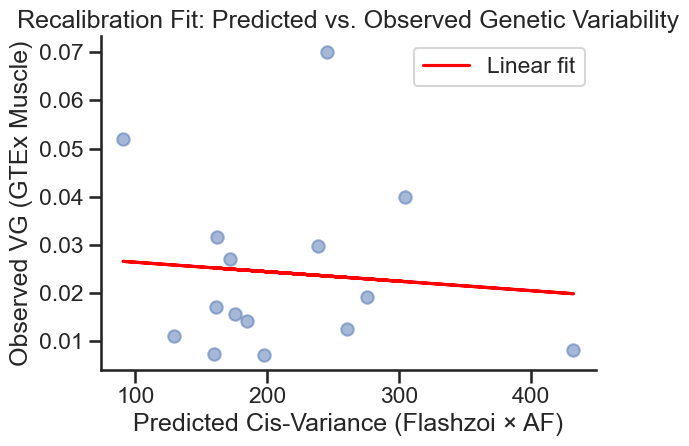

In [38]:
import matplotlib.pyplot as plt

plt.scatter(merged_vg["predicted_cis_variance"], merged_vg["VG_Muscle"], alpha=0.5)
plt.plot(X, reg.predict(X), color="red", label="Linear fit")
plt.xlabel("Predicted Cis-Variance (Flashzoi × AF)")
plt.ylabel("Observed VG (GTEx Muscle)")
plt.title("Recalibration Fit: Predicted vs. Observed Genetic Variability")
plt.legend()
plt.show()

In [ ]:
# TODO: how does it correlate with other gene

### VGH metrics

In [42]:
vgh = pd.read_csv(gene_metrics_vgh, sep="\t", index_col=0)
print("Loaded VGH shape:", vgh.shape)

# Promote index to a column
vgh = vgh.reset_index().rename(columns={"index": "gene_id"})
print("Columns in VGH:")
print(vgh.columns.tolist())

# Add version-stripped gene_id
vgh["gene_base"] = vgh["gene_id"].str.replace(r"\.\d+$", "", regex=True)

# 2. Prepare var_df
if "gene_base" not in var_df.columns:
    var_df["gene_base"] = var_df["gene_id"].str.replace(r"\.\d+$", "", regex=True)

print("Columns in var_df:")
print(var_df.columns.tolist())

# 3. Merge
merged = pd.merge(var_df, vgh, on="gene_base", how="inner")
print("Merged shape:", merged.shape)
print("Columns in merged:")
print(merged.columns.tolist())

expected = ["gene_id", "predicted_cis_variance", "vgh", "median_tpm", "tau"]
available = [col for col in expected if col in merged.columns]

print(merged[available].head())

Loaded VGH shape: (26760, 15)
Columns in VGH:
['gene_id', 'vgh', 'ncRVIS', 'loeuf_score', 'ncGERP', 'RVIS_score', 'ncCADD', 'pHaplo', 'pTriplo', 'Episcore', 'pLI', 'median_tpm', 'num_enh', 'num_super_enh', 'tau', 'vg_eqtl']
Columns in var_df:
['gene_id', 'predicted_cis_variance', 'num_snps', 'mean_AF', 'median_AF', 'mean_DELTA', 'median_DELTA', 'mean_VAR_I', 'median_VAR_I', 'gene_base']
Merged shape: (15, 26)
Columns in merged:
['gene_id_x', 'predicted_cis_variance', 'num_snps', 'mean_AF', 'median_AF', 'mean_DELTA', 'median_DELTA', 'mean_VAR_I', 'median_VAR_I', 'gene_base', 'gene_id_y', 'vgh', 'ncRVIS', 'loeuf_score', 'ncGERP', 'RVIS_score', 'ncCADD', 'pHaplo', 'pTriplo', 'Episcore', 'pLI', 'median_tpm', 'num_enh', 'num_super_enh', 'tau', 'vg_eqtl']
   predicted_cis_variance       vgh  median_tpm       tau
0              197.062469  0.000637    4.995117  0.264753
1              238.118638  0.000512   23.513369  0.244408
2              260.276776  0.013981    8.995594  0.413761
3       

Spearman correlation: SignificanceResult(statistic=-0.14285714285714282, pvalue=0.6115222287644655)
Pearson correlation: PearsonRResult(statistic=0.08664683791433586, pvalue=0.7588081201277121)


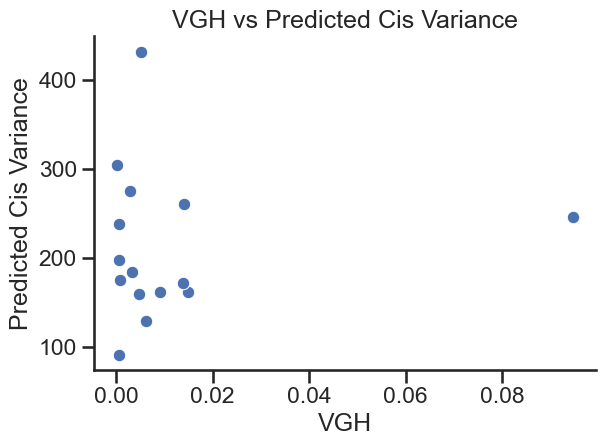

In [43]:
spearman_corr = spearmanr(merged["vgh"], merged["predicted_cis_variance"])
pearson_corr = pearsonr(merged["vgh"], merged["predicted_cis_variance"])

print("Spearman correlation:", spearman_corr)
print("Pearson correlation:", pearson_corr)

sns.scatterplot(data=merged, x="vgh", y=merged["predicted_cis_variance"])
plt.title("VGH vs Predicted Cis Variance")
plt.xlabel("VGH")
plt.ylabel("Predicted Cis Variance")
plt.tight_layout()
plt.show()